# import

In [1]:
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from datetime import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as tsa
from pylab import rcParams 

import itertools # 반복수를 만드는 라이브러리 

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["font.family"] = 'NanumGothicCoding'
mpl.rcParams['axes.unicode_minus'] = False

# 데이터 전처리

## 데이터 로드

In [2]:
df_book = pd.read_csv("/home/piai/바탕화면/A2_간편식/booking_data.csv")
df_cook = pd.read_csv("/home/piai/바탕화면/A2_간편식/Cooking_data_set.csv")
df_cook.dropna(subset=['품목명'], inplace=True)

## 날짜형 이상치 결측치 핸들링

In [3]:
# 수주일자 이상치 제거 - 3개밖에 없는걸 확인함
df_book = df_book.drop(df_book[df_book['수주일자'].isin([0, 21210727, 21210830])].index)

# 수주일자 datetime으로 바꾸기 
df_book['수주일자'] = pd.to_datetime(df_book['수주일자'], format='%Y%m%d')

# '납기일자' column 조건 확인 후 datetime으로 변환 
df_book = df_book[pd.to_numeric(df_book['납기일자'], errors='coerce').notnull()]
df_book['납기일자'] = pd.to_numeric(df_book['납기일자'])
df_book = df_book[df_book['납기일자'] >= 20000000]
df_book = df_book[df_book['납기일자'] <= 20211231]
df_book['납기일자'] = pd.to_datetime(df_book['납기일자'], format='%Y%m%d')

# 파생변수 납품소요일 생성
df_book['납품소요일'] = (df_book['납기일자'] - df_book['수주일자']).dt.days

# 납품소요일 음수 이상치로 판단, 제거 
df_book = df_book[df_book['납품소요일'] >= 0]

# 등장 빈도수가 이상한, 21년 11월 데이터 삭제
df_book = df_book[df_book['수주일자'] <= '2021-10-31']

## 이상치 결측치 핸들링

In [4]:
# 수주품목코드, 수주단위, 수주사업장의 결측치, 출고수량KG의 이상치 제거 
df_book = df_book.dropna(axis=0, subset=['수주품목코드','수주단위','수주사업장'])#.reset_index(drop=True)
df_book=df_book.drop(df_book[df_book["출고수량KG"] < 0].index)

# 수주단가의 이상치를 None으로 변환후 수주품목코드별 수주단가 평균으로 채워넣기 
mask = df_book['수주단가'] <= 0
df_book.loc[mask, '수주단가'] = None
df_book['수주단가'] = df_book['수주단가'].fillna(df_book.groupby('수주품목코드')['수주단가'].transform('mean'))

# 평균 계산이 안 되어 안채워진 None값을 해당 데이터의 기준단가로 채워넣기  
mask = df_book['기준단가'] > 0
df_book.loc[mask, '수주단가'] = df_book['기준단가']

# 수주수량KG 이상치 
df_book=df_book.drop(df_book[df_book["수주수량KG"] < 10].index)

for i in range(4):
    max_index = df_book['수주수량KG'].idxmax()
    df_book.drop(max_index, inplace=True)

# 주주일자 기준 sort
df_book = df_book.sort_values(by='수주일자')

## 품목명 컬럼 생성

In [5]:
codename = dict(df_cook[['품목코드', '품목명']].values)
df_book['품목명'] = df_book['수주품목코드'].map(codename)
df_book.dropna(subset=['품목명'], inplace=True)

## 품목세부분류 컬럼 생성

In [6]:
def func1(row):
    if '볶음밥' in row:
        return '볶음밥'
    elif '소스' in row:
        return '소스'
    elif '마요' in row:
        return '마요'
    elif '비빔밥' in row:
        return '비빔밥'
    elif '나물밥' in row:
        return '비빔밥'
    elif '라이스' in row:
        return '볶음밥'
    elif '필라프' in row:
        return '볶음밥'
    elif '죽' in row:
        return '기타'
    elif '리조또' in row:
        return '기타'
    elif '초밥액' in row:
        return '기타'
    elif "밥" in row:
        return "볶음밥"
    elif "샐러드" in row:
        return "샐러드"
    elif "드레싱" in row:
        return "드레싱"
    elif '양념' in row:
        return '소스'
    else:
        return "기타"
df_book['품목세부분류'] = df_book['품목명'].apply(func1)

## 전처리 최종 확인

In [7]:
df_book.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907837 entries, 2947 to 1755421
Data columns (total 20 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   수주사업장   907837 non-null  float64       
 1   수주일자    907837 non-null  datetime64[ns]
 2   수주일련번호  907837 non-null  int64         
 3   거래처코드   907833 non-null  object        
 4   수주부서    863238 non-null  object        
 5   수주품목코드  907837 non-null  object        
 6   수주단위    907837 non-null  object        
 7   출고수량KG  907837 non-null  float64       
 8   수주수량KG  907837 non-null  float64       
 9   수주단가    906210 non-null  float64       
 10  수주금액    907837 non-null  float64       
 11  부가세금액   907837 non-null  int64         
 12  출하완료여부  907837 non-null  object        
 13  납기일자    907837 non-null  datetime64[ns]
 14  기준단가    907837 non-null  float64       
 15  생산지시    869886 non-null  object        
 16  수주수량    907837 non-null  float64       
 17  납품소요일   907837 non-null  

In [8]:
df_book.tail(2)

,수주사업장,수주일자,수주일련번호,거래처코드,수주부서,수주품목코드,수주단위,출고수량KG,수주수량KG,수주단가,수주금액,부가세금액,출하완료여부,납기일자,기준단가,생산지시,수주수량,납품소요일,품목명,품목세부분류
1755420,20.0,2021-10-31,49,IK2251,400,13D01340,EA,21.96,21.96,2450.0,88200.0,8820,Y,2021-11-01,2450.0,N,0.0,1,곰곰오리엔탈드레싱,드레싱
1755421,20.0,2021-10-31,50,IK2251,400,13D01341,EA,10.26,10.26,2450.0,44100.0,4410,Y,2021-11-01,2450.0,N,0.0,1,곰곰참깨드레싱,드레싱


# EDA 시각화

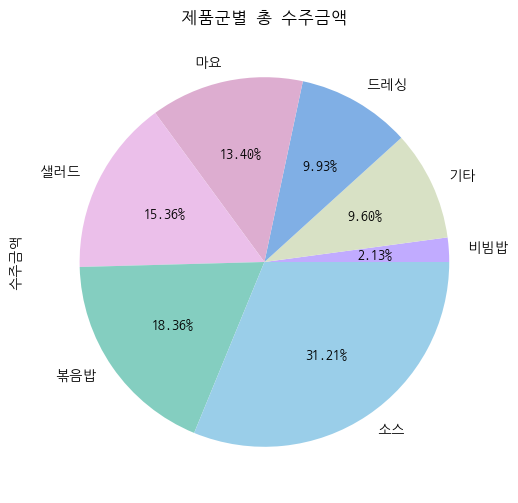

In [12]:
# 제품군별 총 수주금액

df_book_code_sum = df_book.groupby(['품목세부분류']).agg('sum')['수주금액'].sort_values()

df_book_code_sum.plot(kind='pie',figsize=(8,6),title='제품군별 총 수주금액',
                      colors = ['#c1abff', '#d8e1c5', '#80afe5', '#ddadd0', '#ebbfea', '#84cec0', '#9acee9', '#d6c2b6', '#d48c9d', '#dcf6c5'],
                      autopct=lambda p : '{:.2f}%'.format(p), ## 퍼센티지 출력
                     )
plt.show()

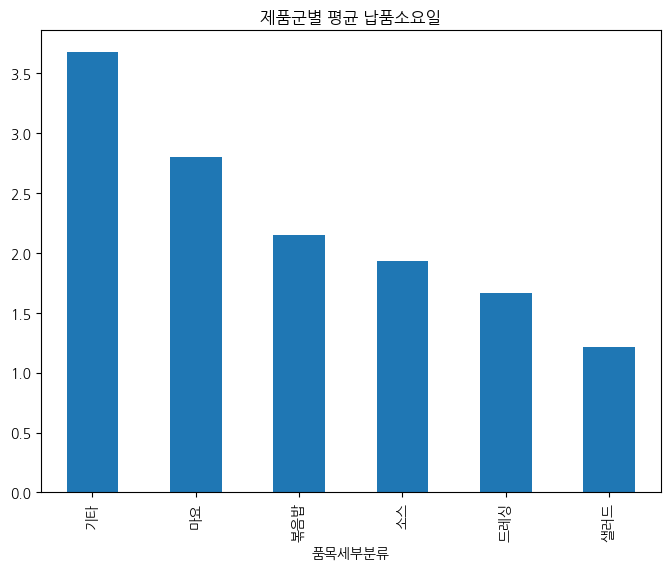

In [211]:
# 제품군별 평균 납품 소요일

mask3 = (df_book['수주일자'] >= '2018-01-01') & (df_book['출하완료여부'] == 'N')
df3 = df_book.loc[mask3]

df_book_code_sum = df3.groupby(['품목세부분류']).agg('mean')['납품소요일'].sort_values(ascending = False)

df_book_code_sum.plot(kind='bar',figsize=(8,6),title='제품군별 평균 납품소요일')
plt.show()

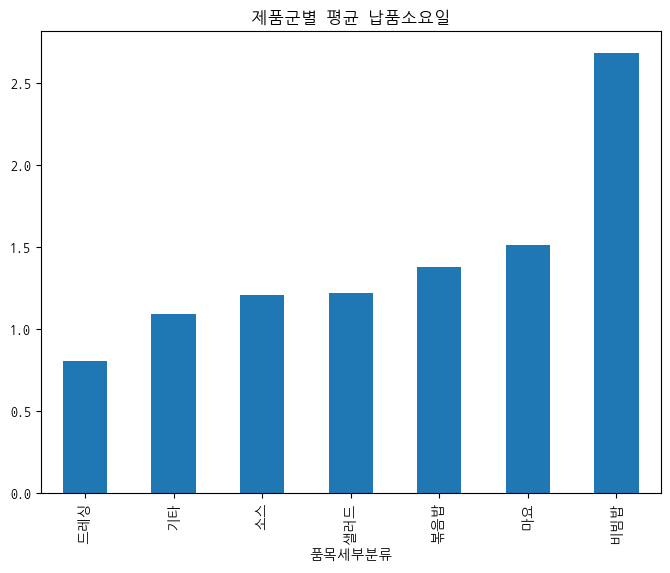

In [14]:
# 제품군별 평균 납품 소요일

mask3 = (df_book['수주일자'] >= '2018-01-01') & (df_book['출하완료여부'] == 'Y')
df3 = df_book.loc[mask3]

df_book_code_sum = df3.groupby(['품목세부분류']).agg('mean')['납품소요일'].sort_values()

df_book_code_sum.plot(kind='bar',figsize=(8,6),title='제품군별 평균 납품소요일')
plt.show()

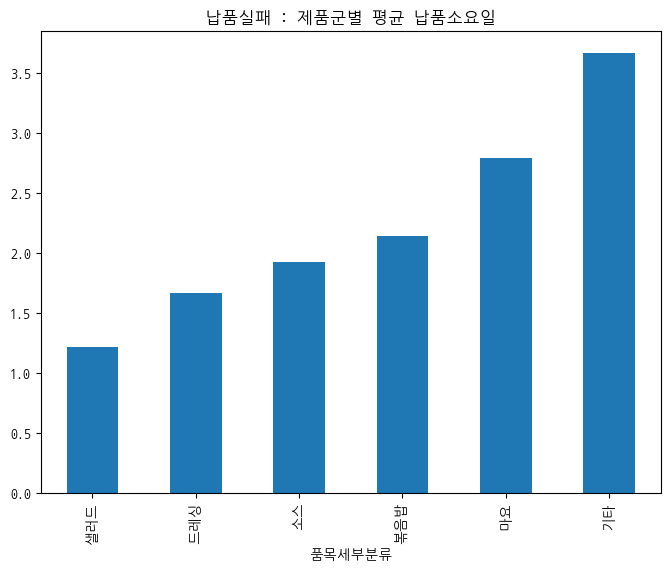

In [15]:
# 납품실패 : 제품군별 평균 납품 소요일

mask = df_book['출하완료여부'] == 'N'
df1 = df_book.loc[mask]

df_book_code_sum = df1.groupby(['품목세부분류']).agg('mean')['납품소요일'].sort_values()

df_book_code_sum.plot(kind='bar',figsize=(8,6),title='납품실패 : 제품군별 평균 납품소요일')
plt.show()

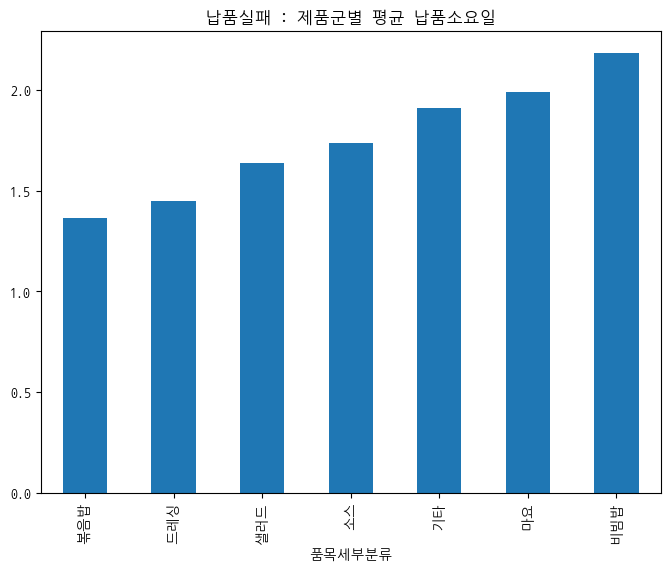

In [16]:
# 납품실패 : 제품군별 평균 납품 소요일

mask = df_book['출하완료여부'] == 'Y'
df1 = df_book.loc[mask]

df_book_code_sum = df1.groupby(['품목세부분류']).agg('mean')['납품소요일'].sort_values()

df_book_code_sum.plot(kind='bar',figsize=(8,6),title='납품실패 : 제품군별 평균 납품소요일')
plt.show()

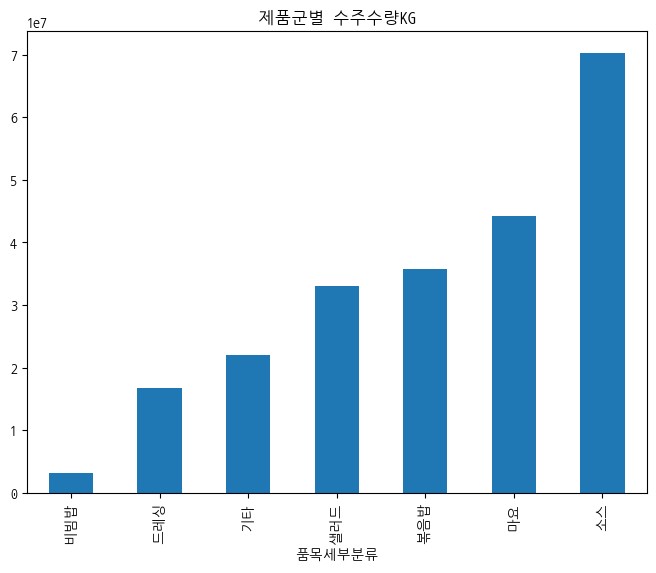

In [17]:
# 제품군별 수주수량KG

df_book_code_sum = df_book.groupby(['품목세부분류']).agg('sum')['수주수량KG'].sort_values()

df_book_code_sum.plot(kind='bar',figsize=(8,6),title='제품군별 수주수량KG')
plt.show()

In [210]:
mask = df_book['수주일자'] >= '2014-01-01'
df4 = df_book.loc[mask]
df_book_code_sum2 = df4.groupby(['품목세부분류']).agg('sum')['수주수량KG'].sort_values()
df_book_code_sum2

품목세부분류
비빔밥    3.167114e+06
드레싱    1.088810e+07
기타     1.425056e+07
샐러드    2.180685e+07
마요     2.742475e+07
볶음밥    3.583490e+07
소스     4.696883e+07
Name: 수주수량KG, dtype: float64

In [209]:
df_book_code_sum = df_book.loc[mask].groupby(['품목세부분류']).agg('sum')['수주수량KG'].sort_values()
df_book_code_sum

품목세부분류
비빔밥    3.167114e+06
드레싱    1.088810e+07
기타     1.425056e+07
샐러드    2.180685e+07
마요     2.742475e+07
볶음밥    3.583490e+07
소스     4.696883e+07
Name: 수주수량KG, dtype: float64

In [218]:
df5 = df4.groupby(['품목세부분류'])

In [221]:
df5.sum()

,수주사업장,수주일련번호,출고수량KG,수주수량KG,수주단가,수주금액,부가세금액,기준단가,수주수량,납품소요일
품목세부분류,,,,,,,,,,
기타,1199580.0,12978113,1.255447e+07,1.425056e+07,1.701715e+08,3.932362e+10,3717449893,-4.962644e+39,7.014574e+06,77498
드레싱,2744340.0,22408444,1.007186e+07,1.088810e+07,3.847167e+08,4.231474e+10,4674225805,-3.024108e+39,3.691859e+06,142365
마요,1652428.0,8847408,2.561843e+07,2.742475e+07,2.360995e+08,5.281890e+10,4556258160,-3.644436e+39,5.103155e+06,81323
볶음밥,3912505.0,22131331,3.157440e+07,3.583490e+07,2.650024e+08,1.168110e+11,11027800207,-6.127034e+39,3.146447e+07,147207
비빔밥,38580.0,426853,2.865465e+06,3.167114e+06,8.122948e+07,1.353890e+10,1352554737,-4.560445e+38,2.613575e+06,4213
샐러드,4262068.0,23756796,2.008969e+07,2.180685e+07,4.057679e+08,6.415872e+10,6434767946,-4.488173e+39,6.856609e+06,187525
소스,6936853.0,60577472,4.204782e+07,4.696883e+07,1.280000e+68,1.375552e+11,12809219428,1.280000e+68,3.273380e+07,365933


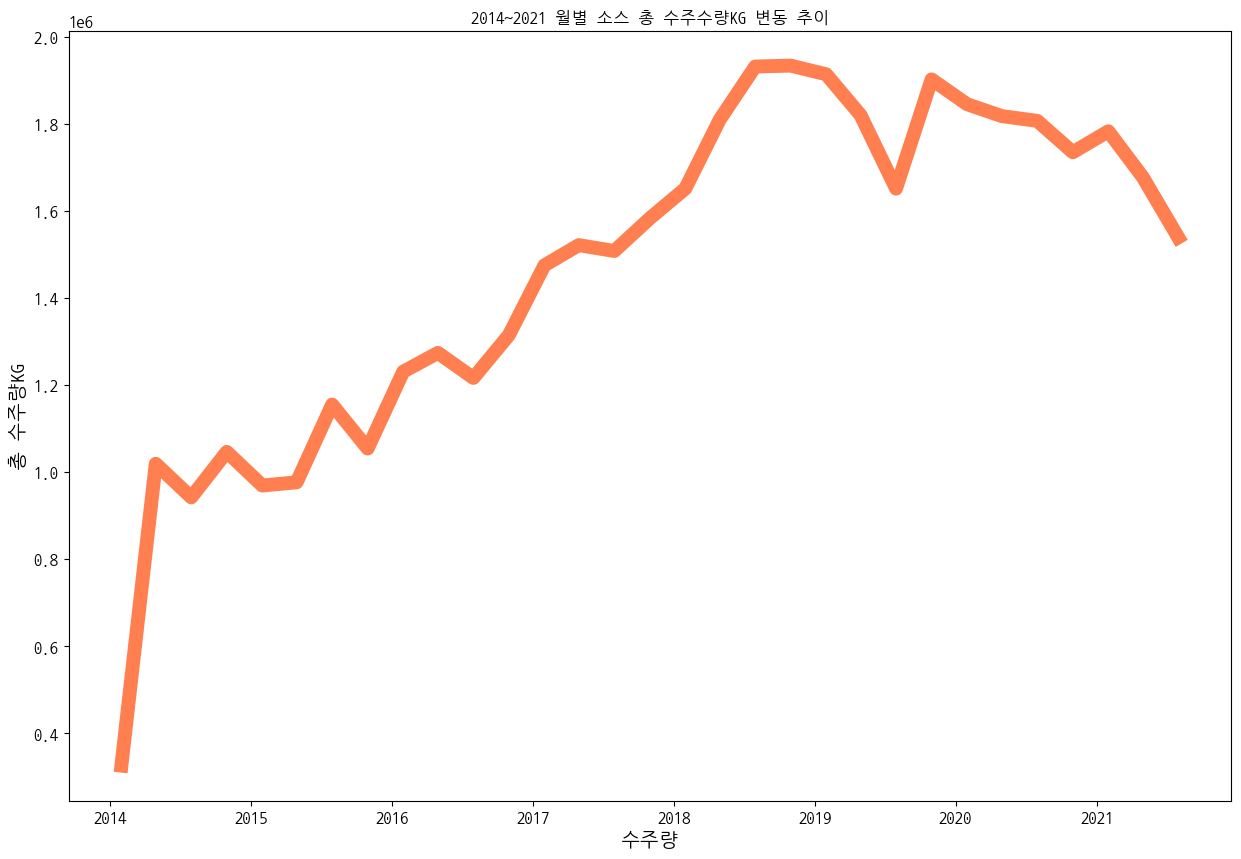

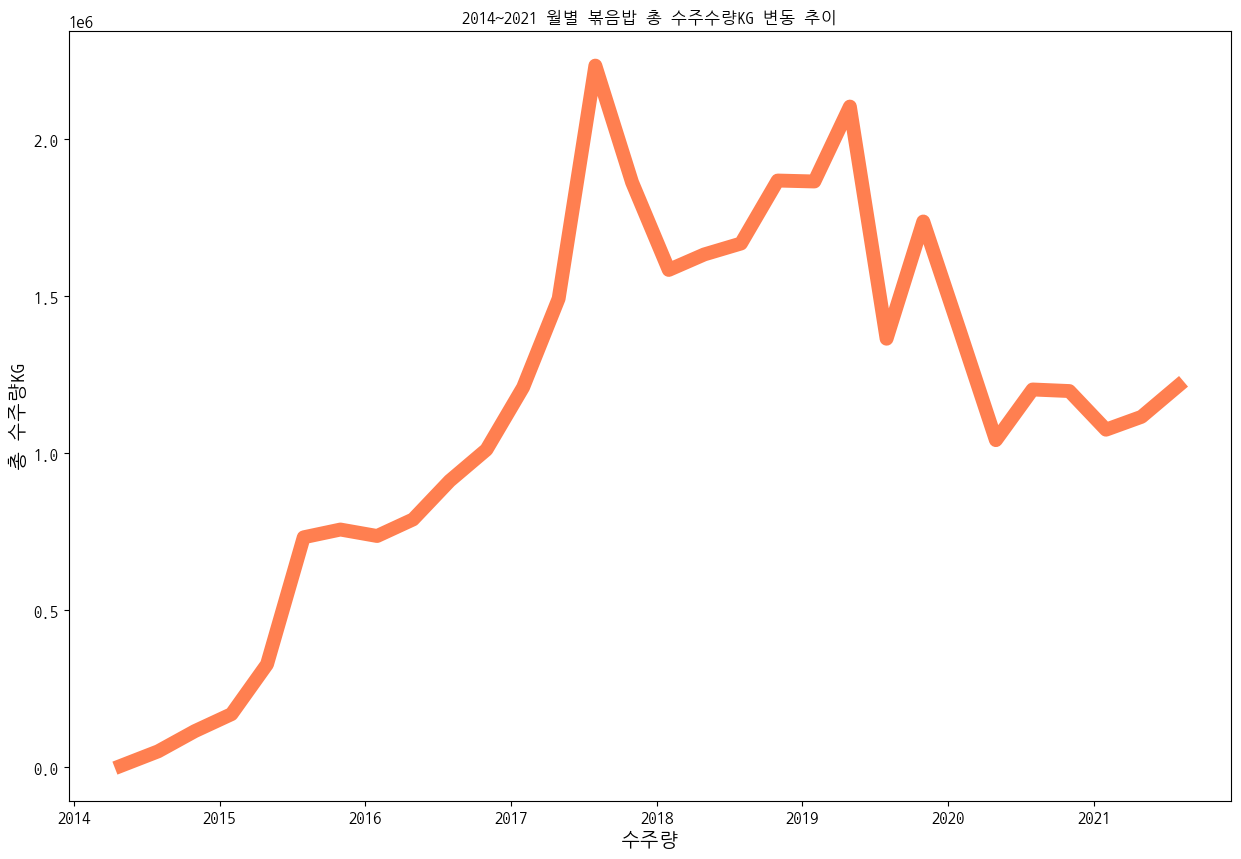

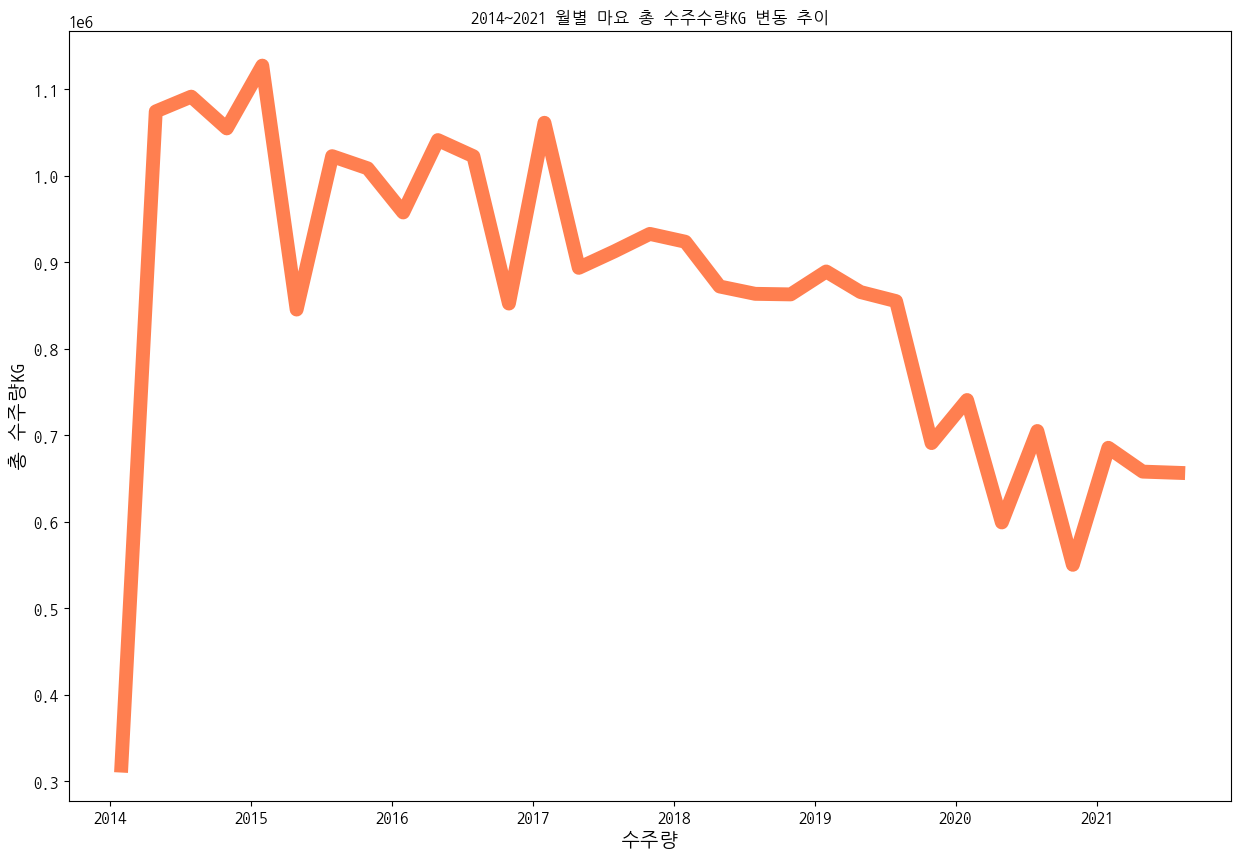

In [225]:
for i in ['소스', '볶음밥', '마요']:
    mask = (df_book['품목세부분류']==i) & (df_book['수주일자'] >= '2014-01-01')
    df_book_dates = df_book.loc[mask, ['수주일자', '수주수량KG']]
    df_book_dates = df_book_dates.sort_values(by='수주일자')
    df_book_dates.set_index('수주일자', inplace=True)    
    df_book_dates_monthly = df_book_dates.resample('3M').sum()
    df_book_dates_monthly = df_book_dates_monthly.iloc[:-1]    
    plt.plot(df_book_dates_monthly.index, df_book_dates_monthly['수주수량KG'], color = '#FF7F50', linewidth="10.0")
    plt.xlabel('수주량')
    plt.ylabel('총 수주량KG')
    plt.title('2014~2021 월별 {} 총 수주수량KG 변동 추이'.format(i))
    plt.show()

In [212]:
df_book.head()

,수주사업장,수주일자,수주일련번호,거래처코드,수주부서,수주품목코드,수주단위,출고수량KG,수주수량KG,수주단가,수주금액,부가세금액,출하완료여부,납기일자,기준단가,생산지시,수주수량,납품소요일,품목명,품목세부분류
2947,20.0,2003-11-08,5,IJ1470,SU0001,13D03020,kg,240.0,240.0,2248.00,539520.0,53952,Y,2003-11-11,0.0,Y,0.0,3,시아스키위드레싱,드레싱
2968,20.0,2003-11-11,8,IJ1470,su0060,13D01020,kg,240.0,240.0,2975.00,714000.0,71400,Y,2003-11-12,0.0,Y,0.0,1,케이준샐러드드레싱,샐러드
2978,20.0,2003-11-13,4,IJ1470,su0060,13D03020,kg,300.0,300.0,2248.00,674400.0,67440,Y,2003-11-14,0.0,Y,0.0,1,시아스키위드레싱,드레싱
2987,20.0,2003-11-17,9,IJ1470,SU0001,13S19010,kg,936.0,936.0,2012.00,1883232.0,188323,Y,2003-11-25,0.0,Y,0.0,8,오레또미트스파게티소스,소스
3007,20.0,2003-11-19,6,IJ1608,SU0001,13S01010,kg,306.0,306.0,2733.34,836402.0,83640,Y,2003-11-24,0.0,Y,0.0,5,시아스비프스파게티소스,소스


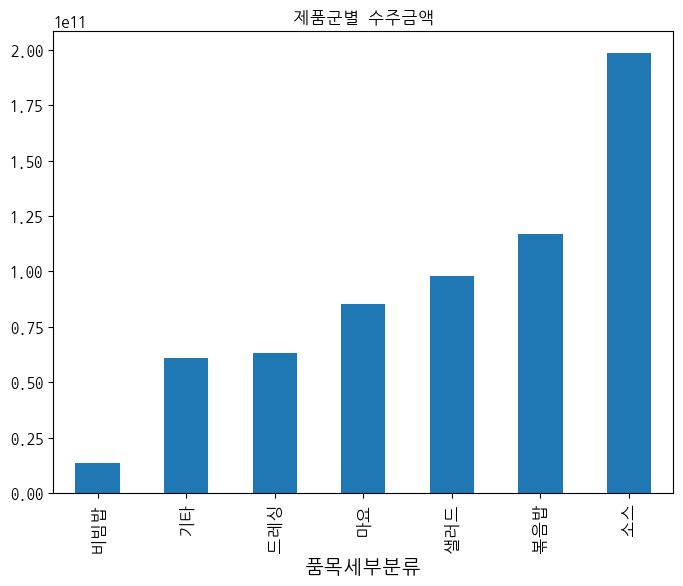

In [157]:
# 제품군별 수주매출

df_book_code_sum = df_book.groupby(['품목세부분류']).agg('sum')['수주금액'].sort_values()

df_book_code_sum.plot(kind='bar',figsize=(8,6),title='제품군별 수주금액')
plt.show()

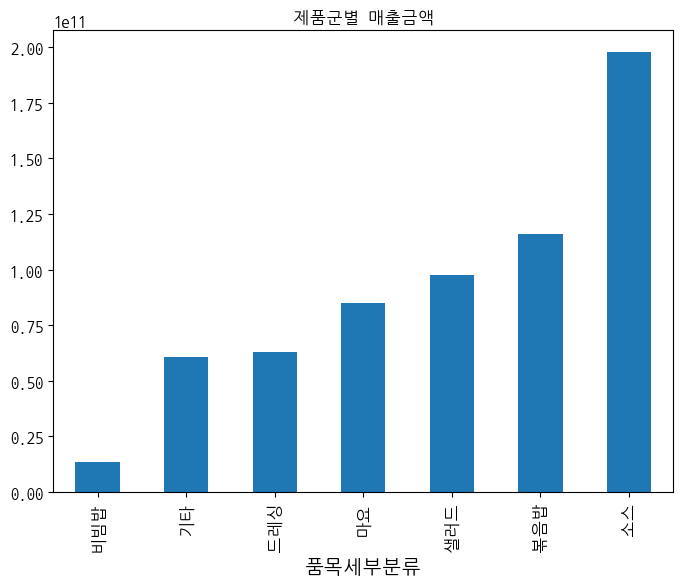

In [159]:
# 제품군별 매출금액

mask = df_book['출하완료여부'] == 'Y'
df1 = df_book.loc[mask]

df_book_code_sum = df1.groupby(['품목세부분류']).agg('sum')['수주금액'].sort_values()

df_book_code_sum.plot(kind='bar',figsize=(8,6),title='제품군별 매출금액')
plt.show()

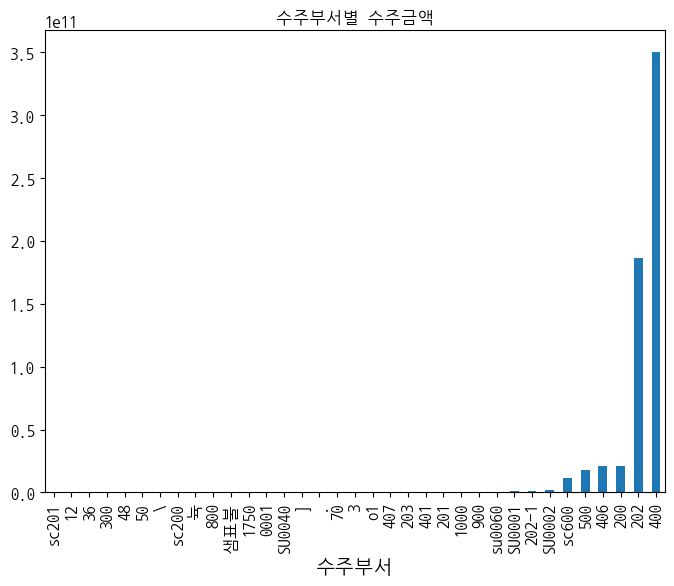

In [161]:
# 제품군별 수주매출

df_book_code_sum = df_book.groupby(['수주부서']).agg('sum')['수주금액'].sort_values()

df_book_code_sum.plot(kind='bar',figsize=(8,6),title='수주부서별 수주금액')
plt.show()

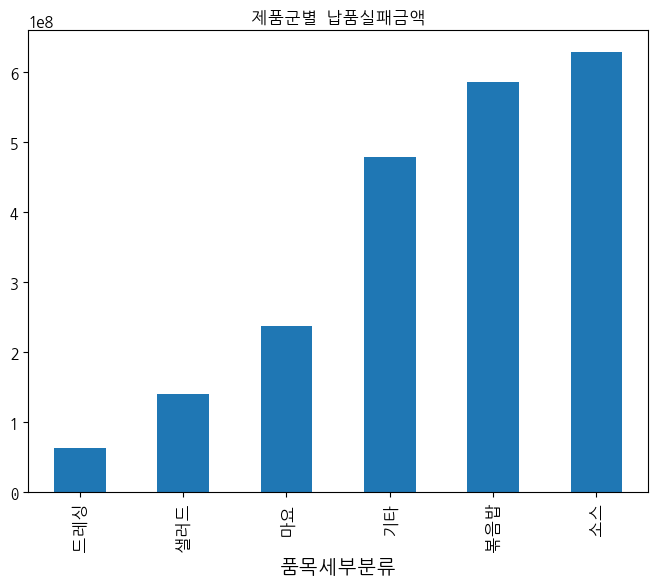

In [163]:
# 제품군별 납품실패 금액

mask = df_book['출하완료여부'] == 'N'
df1 = df_book.loc[mask]

df_book_code_sum = df1.groupby(['품목세부분류']).agg('sum')['수주금액'].sort_values()

df_book_code_sum.plot(kind='bar',figsize=(8,6),title='제품군별 납품실패금액')
plt.show()

In [166]:
mask = df_book['품목세부분류'] == '기타'
df2 = df_book.loc[mask]
print(df2['품목명'].unique())

['브레더믹스' '핫배타믹스' '믹스파우다' 'PALAMA KALBI SAUCE' '파인애플칵테일베이스' '석류사과칵테일베이스'
 '농축레몬과즙20kg' '초대리-B 20kg' '미스터피자레몬에이드' '자몽오렌지칵테일베이스' '스마트이팅칼로리를줄인머스타드'
 '스트로베리시럽' '베스트셀렉트허브칠리595g' '메이플시럽' '자연드림 상큼한 토마토케찹' '이마트 야채케챱295g'
 '이마트 야채케챱600g' '미스터피자블루베리시럽엠피' '요리愛[애]요리당' '후레쉬레몬에이드' '키위쿨라타'
 '자연드림 상큼한 토마토케찹595g' '나가사키베이스' '오렌지생맥주베이스1kg' '흑초차베이스' '토마토케찹2kg'
 '토마토케찹18kg' '비타복분자딸기칵테일베이스' '비타키위칵테일베이스' '블루베리시럽-KFC' '초밥액-W'
 '짚쌩비타파인애플베이스' '애플민트향에이드' '베스트셀렉트머스타드520g' '짚쌩뉴비타복분자베이스' '사우전아일랜드-K'
 '감귤칵테일베이스' '메론에이드' '허니브라운머스타드-E' '토마토케찹153kg' '샘표잘익은고추장에상큼한레몬초고추장'
 '샘표잘익은고추장에생야채가득비빔국수' '김치찌개용분말' '트레이더스가쓰오다시국물' '모히토칵테일베이스' '블루베리리플' '갈릭시럽'
 '유기아가베시럽335g/올가홀' '유기아가베시럽665g/올가홀' '믹스참치스프레드180g' '망고블라스트' '아몬드호두110g'
 '스위트머스타드110g' '크리미시저-P' '쉐프메이드세서미오리엔탈' '스위트머스타드-P' '스위트머스타드-P 510g'
 '싱싱한토마토로만든맛이진한토마토케첩600g' '모히토칵테일베이스-2' '복합스파이스(15.4kg)' '본뽀스또베이컨크림파스타'
 '샘표 BULGOGI SAUCE964g(미국수출)' '샘표 KALBI SAUCE964g(미국수출)'
 '샘표 HOT KALBI SAUCE964g(미국수출)' '요리애허니머스타드260g' '네네토마토케첩153kg'
 '생과일복분자딸기베이스' '단호박죽280g' '자연드림 상큼한 토마토케찹280g' '쌀

In [ ]:
# 가루류, 케찹, 시럽, 베이스

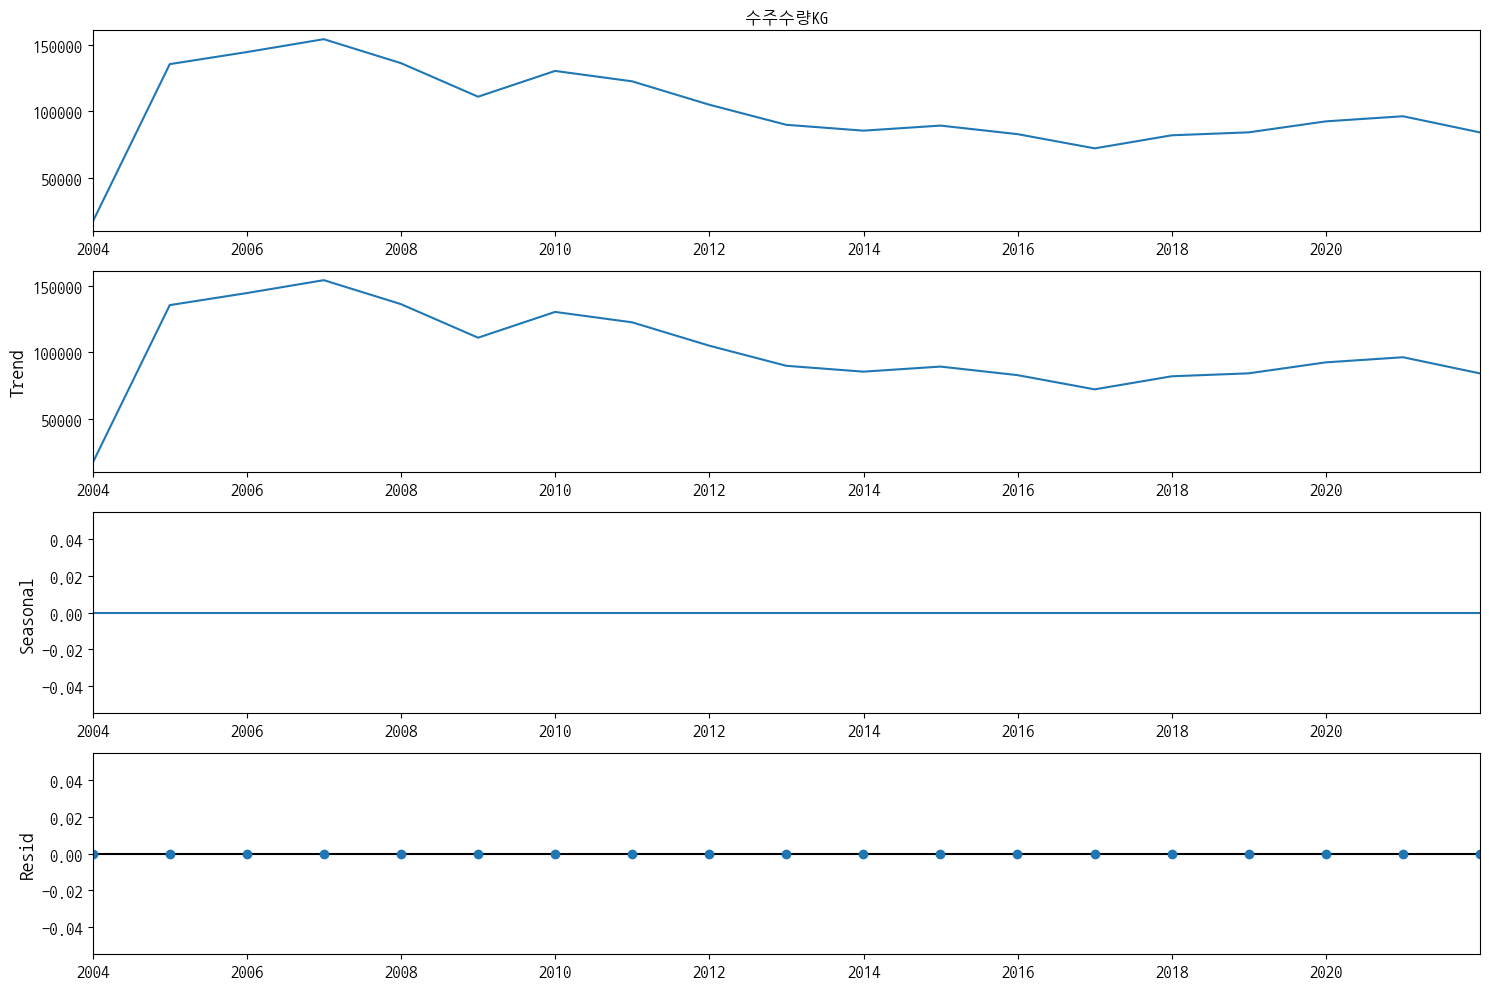

In [183]:
s_all = pd.pivot_table(data=df_book, index='수주일자', values='수주수량KG')
s_all.head()

# 특정 주기 단위로 분할
y_all = s_all['수주수량KG'].resample('1Y').sum()

model_series = tsa.seasonal_decompose(y_all, model='additive')
fig = model_series.plot()
plt.show()

In [ ]:
df_book_kg = df_book_kg.sort_values(by='수주일자')
df_book_dates = df_book_kg[['수주일자', '수주수량KG']]

# '수주일자' 를 df index 로 바꾸기 
df_book_dates.set_index('수주일자', inplace=True)

# 시계열 그래프 
plt.plot(df_book_dates)
plt.xlabel('수주일자')
plt.ylabel('수주수량KG')
plt.title('전체 일자 수주수량 변화')
plt.show()

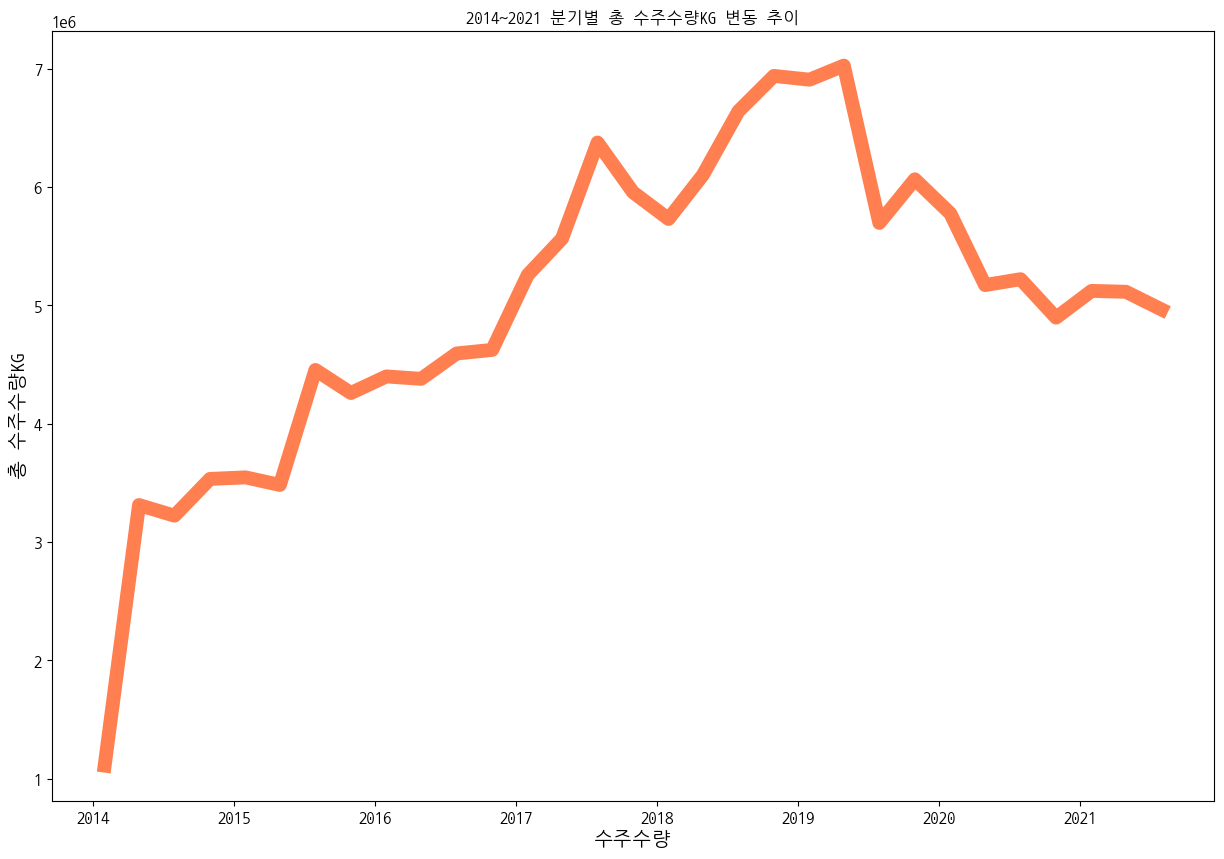

In [200]:
mask = (df_book['수주일자'] >= '2014-01-01')
df_book_dates = df_book.loc[mask, ['수주일자', '수주수량KG']]
df_book_dates = df_book_dates.sort_values(by='수주일자')
df_book_dates.set_index('수주일자', inplace=True)
df_book_dates_monthly = df_book_dates.resample('3M').sum()
df_book_dates_monthly = df_book_dates_monthly.iloc[:-1]
plt.plot(df_book_dates_monthly.index, df_book_dates_monthly['수주수량KG'], color = '#FF7F50', linewidth="10.0")
plt.xlabel('수주수량')
plt.ylabel('총 수주수량KG')
plt.title('2014~2021 분기별 총 수주수량KG 변동 추이')
plt.show()

In [ ]:
# 요일별 수주량 변화 => 어떤 요일이 얼마나 생산 여력이 남는지 증명하고자 한다.
# 요일 컬럼 필요



In [75]:
df_book.head()

,수주사업장,수주일자,수주일련번호,거래처코드,수주부서,수주품목코드,수주단위,출고수량KG,수주수량KG,수주단가,...,납기일자,기준단가,생산지시,수주수량,납품소요일,품목명,품목세부분류,수주요일,수주요일Num,수주년
2947,20.0,2003-11-08,5,IJ1470,SU0001,13D03020,kg,240.0,240.0,2248.00,...,2003-11-11,0.0,Y,0.0,3,시아스키위드레싱,드레싱,Saturday,5,2003
2968,20.0,2003-11-11,8,IJ1470,su0060,13D01020,kg,240.0,240.0,2975.00,...,2003-11-12,0.0,Y,0.0,1,케이준샐러드드레싱,샐러드,Tuesday,1,2003
2978,20.0,2003-11-13,4,IJ1470,su0060,13D03020,kg,300.0,300.0,2248.00,...,2003-11-14,0.0,Y,0.0,1,시아스키위드레싱,드레싱,Thursday,3,2003
2987,20.0,2003-11-17,9,IJ1470,SU0001,13S19010,kg,936.0,936.0,2012.00,...,2003-11-25,0.0,Y,0.0,8,오레또미트스파게티소스,소스,Monday,0,2003
3007,20.0,2003-11-19,6,IJ1608,SU0001,13S01010,kg,306.0,306.0,2733.34,...,2003-11-24,0.0,Y,0.0,5,시아스비프스파게티소스,소스,Wednesday,2,2003


In [76]:
df_book['수주요일'] = df_book['수주일자'].dt.day_name()

In [77]:
df_book['수주요일Num'] = df_book['수주일자'].dt.weekday

In [78]:
df_book20 = df_book[df_book['수주일자'].between('2020-01-01', '2021-12-31')]
df_book20.head()

,수주사업장,수주일자,수주일련번호,거래처코드,수주부서,수주품목코드,수주단위,출고수량KG,수주수량KG,수주단가,...,납기일자,기준단가,생산지시,수주수량,납품소요일,품목명,품목세부분류,수주요일,수주요일Num,수주년
1429285,20.0,2020-01-01,51,IJ9555,406,16A02023,kg,0.0,43.0,3240.0,...,2020-01-14,3240.0,N,0.0,13,NEW단호박샐러드-1,샐러드,Wednesday,2,2020
1429288,20.0,2020-01-01,54,IJ9555,406,13D01156,kg,0.0,10.0,7470.0,...,2020-01-14,7470.0,N,0.0,13,시아스오리엔탈소스,소스,Wednesday,2,2020
1429289,20.0,2020-01-01,55,IJ9555,406,13K01304,kg,0.0,18.0,6480.0,...,2020-01-14,6480.0,N,0.0,13,데미그라스소스-P,소스,Wednesday,2,2020
1421654,20.0,2020-01-01,10,IO901,400,13K02080,kg,48.0,48.0,3500.0,...,2020-01-01,3500.0,N,0.0,0,시아스살사소스,소스,Wednesday,2,2020
1429287,20.0,2020-01-01,53,IJ9555,406,16A01062,kg,0.0,61.0,3240.0,...,2020-01-14,3240.0,N,0.0,13,시아스감자샐러드,샐러드,Wednesday,2,2020


In [80]:
df_book20.groupby('수주요일').count()

,수주사업장,수주일자,수주일련번호,거래처코드,수주부서,수주품목코드,수주단위,출고수량KG,수주수량KG,수주단가,...,출하완료여부,납기일자,기준단가,생산지시,수주수량,납품소요일,품목명,품목세부분류,수주요일Num,수주년
수주요일,,,,,,,,,,,,,,,,,,,,,
Friday,27958,27958,27958,27958,22296,27958,27958,27958,27958,27819,...,27958,27958,27958,26317,27958,27958,27958,27958,27958,27958
Monday,39556,39556,39556,39555,29892,39556,39556,39556,39556,39426,...,39556,39556,39556,36891,39556,39556,39556,39556,39556,39556
Saturday,1677,1677,1677,1677,1673,1677,1677,1677,1677,1651,...,1677,1677,1677,1500,1677,1677,1677,1677,1677,1677
Sunday,3951,3951,3951,3951,3948,3951,3951,3951,3951,3945,...,3951,3951,3951,3059,3951,3951,3951,3951,3951,3951
Thursday,31379,31379,31379,31379,25566,31379,31379,31379,31379,31271,...,31379,31379,31379,28877,31379,31379,31379,31379,31379,31379
Tuesday,33134,33134,33134,33134,27151,33134,33134,33134,33134,33031,...,33134,33134,33134,30836,33134,33134,33134,33134,33134,33134
Wednesday,29545,29545,29545,29542,23526,29545,29545,29545,29545,29405,...,29545,29545,29545,27334,29545,29545,29545,29545,29545,29545


In [84]:
table1 = pd.pivot_table(df_book20[df_book20['품목세부분류']=='소스'], index = ['수주요일Num'], values = '수주수량KG', aggfunc = 'mean')
table1

,수주수량KG
수주요일Num,
0,171.524154
1,209.336168
2,198.455150
3,194.086382
4,218.154057
5,241.363316
6,249.916668


In [85]:
table1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 0 to 6
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   수주수량KG  7 non-null      float64
dtypes: float64(1)
memory usage: 112.0 bytes


<BarContainer object of 7 artists>

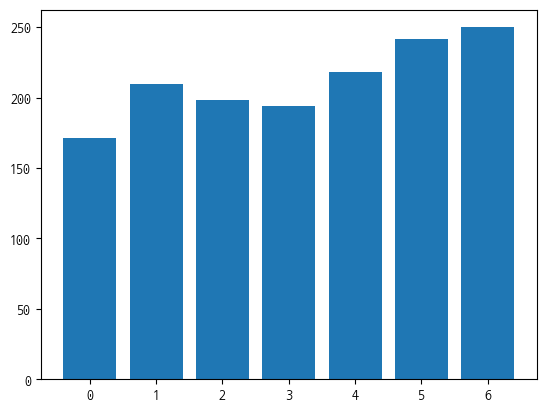

In [86]:
plt.bar(data=table1, x=table1.index ,height='수주수량KG')

In [70]:
# day_name = {0: '월', 1: '화', 2: '수', 3: '목', 4: '금', 5: '토', 6: '일'}
# df_book20['수주요일Num'] = df_book20['수주요일Num'].replace(day_name)

In [71]:
df_book20.head()

,수주사업장,수주일자,수주일련번호,거래처코드,수주부서,수주품목코드,수주단위,출고수량KG,수주수량KG,수주단가,...,출하완료여부,납기일자,기준단가,생산지시,수주수량,납품소요일,품목명,품목세부분류,수주요일,수주요일Num
1429285,20.0,2020-01-01,51,IJ9555,406,16A02023,kg,0.0,43.0,3240.0,...,Y,2020-01-14,3240.0,N,0.0,13,NEW단호박샐러드-1,샐러드,Wednesday,수
1429288,20.0,2020-01-01,54,IJ9555,406,13D01156,kg,0.0,10.0,7470.0,...,Y,2020-01-14,7470.0,N,0.0,13,시아스오리엔탈소스,소스,Wednesday,수
1429289,20.0,2020-01-01,55,IJ9555,406,13K01304,kg,0.0,18.0,6480.0,...,Y,2020-01-14,6480.0,N,0.0,13,데미그라스소스-P,소스,Wednesday,수
1421654,20.0,2020-01-01,10,IO901,400,13K02080,kg,48.0,48.0,3500.0,...,Y,2020-01-01,3500.0,N,0.0,0,시아스살사소스,소스,Wednesday,수
1429287,20.0,2020-01-01,53,IJ9555,406,16A01062,kg,0.0,61.0,3240.0,...,Y,2020-01-14,3240.0,N,0.0,13,시아스감자샐러드,샐러드,Wednesday,수


In [49]:
df_book2020 = df_book[df_book['수주일자'].between('2020-01-01', '2020-12-31')]

df_book2020.groupby(['품목세부분류','출하완료여부'])['수주금액'].sum()


# table1 = pd.pivot_table(df_book2020[df_book2020['품목세부분류']=='소스'], index = ['수주요일Num'], values = '수주수량KG', aggfunc = 'sum')
# table1

품목세부분류  출하완료여부
기타      N         1.534192e+08
        Y         6.753639e+09
드레싱     N         4.020297e+07
        Y         3.831252e+09
마요      N         1.086084e+08
        Y         4.795660e+09
볶음밥     N         2.013480e+08
        Y         1.406602e+10
비빔밥     Y         3.594010e+07
샐러드     N         6.779443e+07
        Y         7.016223e+09
소스      N         3.232278e+08
        Y         2.064944e+10
Name: 수주금액, dtype: float64

In [50]:
df_book2020.groupby(['품목세부분류'])['수주금액'].sum()

품목세부분류
기타     6.907058e+09
드레싱    3.871455e+09
마요     4.904268e+09
볶음밥    1.426737e+10
비빔밥    3.594010e+07
샐러드    7.084018e+09
소스     2.097266e+10
Name: 수주금액, dtype: float64

In [52]:
maxdf = df_book20.groupby('수주일자').sum()

In [53]:
maxdf.describe()

,수주사업장,수주일련번호,출고수량KG,수주수량KG,수주단가,수주금액,부가세금액,기준단가,수주수량,납품소요일,수주요일Num
count,655.000000,655.000000,655.000000,655.000000,6.550000e+02,6.550000e+02,6.550000e+02,6.550000e+02,655.000000,655.000000,655.000000
mean,7581.543511,73239.274809,47739.185669,56921.529018,8.328107e+05,1.611563e+08,1.561690e+07,8.180568e+05,38261.522137,291.247328,504.250382
std,4986.086312,69972.608338,34486.899185,36493.736974,5.200949e+05,1.065696e+08,1.040447e+07,5.124415e+05,31318.739459,332.575613,447.467404
min,20.000000,1.000000,0.000000,10.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,1160.000000,3094.500000,10287.932500,17876.930000,2.170093e+05,5.153087e+07,3.876917e+06,2.147255e+05,13145.000000,54.000000,99.000000
50%,9160.000000,68359.000000,55479.245000,65401.730000,9.936045e+05,1.784980e+08,1.779972e+07,9.733650e+05,35251.000000,311.000000,357.000000
75%,10800.000000,90537.000000,73614.015000,81627.805000,1.184933e+06,2.313104e+08,2.272654e+07,1.158823e+06,55075.000000,396.000000,907.500000
max,20340.000000,409405.000000,175070.565000,186826.570000,2.054912e+06,6.389857e+08,6.443144e+07,2.021801e+06,253068.000000,6720.000000,1956.000000


In [54]:
df_book.head(1)

,수주사업장,수주일자,수주일련번호,거래처코드,수주부서,수주품목코드,수주단위,출고수량KG,수주수량KG,수주단가,...,출하완료여부,납기일자,기준단가,생산지시,수주수량,납품소요일,품목명,품목세부분류,수주요일,수주요일Num
2947,20.0,2003-11-08,5,IJ1470,SU0001,13D03020,kg,240.0,240.0,2248.0,...,Y,2003-11-11,0.0,Y,0.0,3,시아스키위드레싱,드레싱,Saturday,5


In [55]:
df_book["수주년"] = df_book['수주일자'].dt.year

In [58]:
df_book.groupby("수주년")["수주수량KG"].sum()

수주년
2003    5.186700e+04
2004    4.576606e+05
2005    7.679700e+05
2006    1.710564e+06
2007    2.432582e+06
2008    4.028574e+06
2009    7.230667e+06
2010    1.003261e+07
2011    1.163715e+07
2012    1.296731e+07
2013    1.360145e+07
2014    1.353638e+07
2015    1.632519e+07
2016    1.864100e+07
2017    2.329302e+07
2018    2.622001e+07
2019    2.504190e+07
2020    2.069774e+07
2021    1.658586e+07
Name: 수주수량KG, dtype: float64

In [66]:
# 제품군별 납품실패 금액

mask = df_book['출하완료여부'] == 'N'
df1 = df_book.loc[mask]

df1.groupby(['수주년']).size()


# df_book_year_non['수주단가'].plot(kind='bar',figsize=(8,6),title='연도별 납품실패')
# plt.show()

수주년
2020    1171
2021     632
dtype: int64

# TimeSeries : ARIMA 모델

* 분해 시계열
    - 시계열에 영향을 주는 일반적 요인을 시계열에서 분리해 분석하는 방법 
    - 계절요인 Seasonal
    - 추세요인 Trend 
    - 순환요인 Cyclical 
    - 불규칙요인 Irregular

## 납품실패량이 높은 주요 품목 : 데이터 프레임 분리

In [18]:
# 납품실패량 1위 소스 : 985 개
mask_source = df_book['품목세부분류'] == '소스'
df_book_source = df_book.loc[mask_source]

# 납품실패량 2위 샐러드 : 356 개
mask_salad = df_book['품목세부분류'] == '샐러드'
df_book_salad = df_book.loc[mask_salad]

# 납품실패량 3위 볶음밥 : 305 개
mask_Frice = df_book['품목세부분류'] == '볶음밥'
df_book_Frice = df_book.loc[mask_Frice]

# 납품실패량 4위 드레싱 : 249 개
mask_dressing = df_book['품목세부분류'] == '마요'
df_book_dressing = df_book.loc[mask_dressing]

## 주요 품목 별 타임시리즈용 시리즈

In [16]:
# 소스
s_source = pd.pivot_table(data=df_book_source, index='수주일자', values='수주수량KG')
s_source.head()

,수주수량KG
수주일자,
2003-11-17,936.0
2003-11-19,804.0
2003-11-20,1800.0
2003-11-21,216.0
2003-11-24,900.0


In [17]:
# 특정 주기 단위로 분할
y_source = s_source['수주수량KG'].resample('1M').mean()

In [18]:
# 샐러드
s_salad = pd.pivot_table(data=df_book_salad, index='수주일자', values='수주수량KG')
s_salad.head()

,수주수량KG
수주일자,
2003-11-11,240.0
2003-11-24,120.0
2003-11-28,240.0
2003-12-10,12.0
2003-12-11,120.0


In [19]:
# 특정 주기 단위로 분할
y_salad = s_salad['수주수량KG'].resample('1M').mean()

In [20]:
# 볶음밥
s_Frice = pd.pivot_table(data=df_book_Frice, index='수주일자', values='수주수량KG')
s_Frice.head()

,수주수량KG
수주일자,
2014-04-10,27.0
2014-04-11,27.0
2014-04-14,40.5
2014-04-15,45.0
2014-04-16,180.0


In [21]:
# 특정 주기 단위로 분할
y_Frice = s_Frice['수주수량KG'].resample('1M').mean()

In [20]:
# 드레싱
s_dressing = pd.pivot_table(data=df_book_dressing, index='수주일자', values='수주수량KG')
s_dressing.head()

,수주수량KG
수주일자,
2007-10-09,1313.333333
2007-10-15,40.000000
2007-10-18,10000.000000
2007-10-31,1516.666667
2007-11-01,10000.000000


In [21]:
# 특정 주기 단위로 분할
y_dressing = s_dressing['수주수량KG'].resample('1M').mean()

## 시계열 모델링 시작

In [24]:
rcParams['figure.figsize'] = 15,10

#차트 기본 크기 설정
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

### 소스

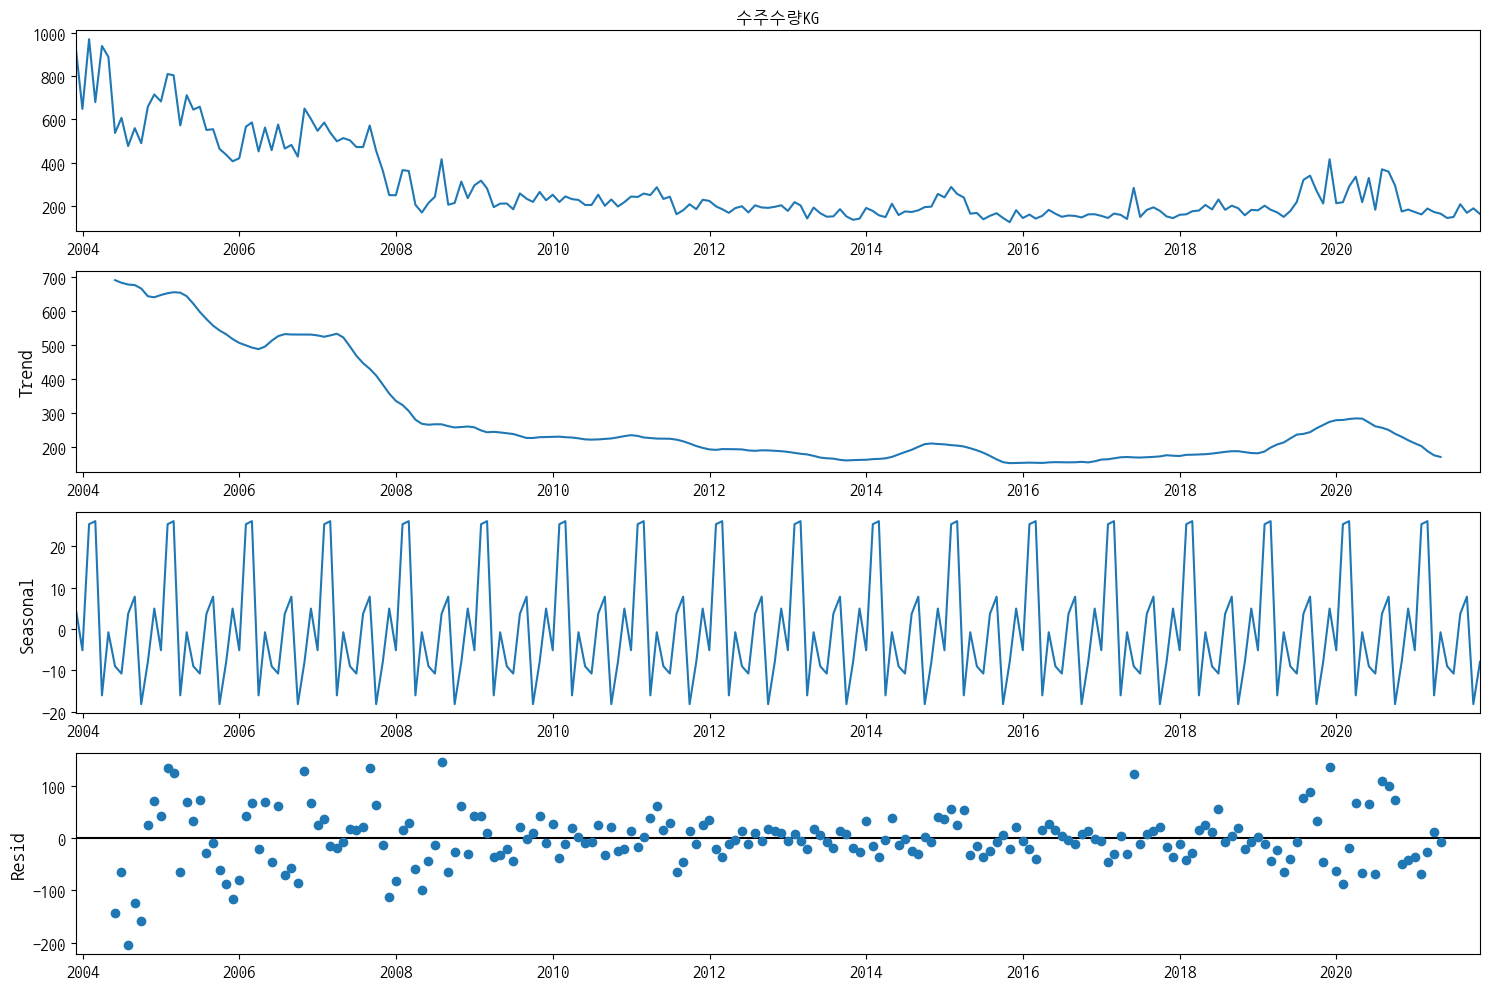

In [48]:
model_series = tsa.seasonal_decompose(y_source, model='additive')
fig = model_series.plot()
plt.show()

In [49]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [50]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [51]:
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [52]:
param_list = []
param_seasonal_list = []
results_AIC_list = []

In [53]:
for param in pdq:
     for param_seasonal in seasonal_pdq:
        try:
            mod = tsa.statespace.SARIMAX(y_source,order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            param_list.append(param)
            param_seasonal_list.append(param_seasonal)
            results_AIC_list.append(results.aic)
        except:
             continue

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.20317D+00    |proj g|=  8.74237D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   2.865D-06   7.203D+00
  F =   7.2029430286874296     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.4

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.73579D+00    |proj g|=  3.86947D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   3.129D-07   5.735D+00
  F =   5.7353543744576063     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.3

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.53424D+00    |proj g|=  6.14598D-01

At iterate    5    f=  5.52091D+00    |proj g|=  2.34559D-01

At iterate   10    f=  5.51966D+00    |proj g|=  3.90417D-03

At iterate   15    f=  5.51959D+00    |proj g|=  6.65843D-02

At iterate   20    f=  5.51716D+00    |proj g|=  1.53879D-01

At iterate   25    f=  5.51670D+00    |proj g|=  3.03041D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     27      1     0     0   3.030D-05   5.517D+00
  F 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.32251D+00    |proj g|=  9.68971D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     23      1     0     0   1.468D-06   5.322D+00
  F =   5.3224323242955256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.88921D+00    |proj g|=  2.85377D-01

At iterate    5    f=  6.83638D+00    |proj g|=  1.84962D-03

At iterate   10    f=  6.83602D+00    |proj g|=  4.04376D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.35406D+00    |proj g|=  2.39296D-03

At iterate   10    f=  6.35026D+00    |proj g|=  4.50173D-02

At iterate   15    f=  5.96576D+00    |proj g|=  1.23844D+00

At iterate   20    f=  5.89849D+00    |proj g|=  2.15165D-02

At iterate   25    f=  5.89838D+00    |proj g|=  3.44210D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     34      1     0     0   7.765D-07   5.898D+00
  F =   5.8983839305504553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13769D+00    |proj g|=  2.75597D-02

At iterate    5    f=  5.13665D+00    |proj g|=  2.37627D-02

At iterate   10    f=  5.11139D+00    |proj g|=  1.70706D-01

At iterate   15    f=  5.10115D+00    |proj g|=  1.98924D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   1.989D-05   5.101D+00
  F =   5.1011467736663496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate   20    f=  5.48705D+00    |proj g|=  6.06521D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     32      1     0     0   2.035D-06   5.487D+00
  F =   5.4870420405702651     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.29937D+00    |proj g|=  3.63405D-02

At iterate    5    f=  6.29427D+00    |proj g|=  2.72402D-03

At iterate   10    f=  6.28288D+00    |proj g|=  4.18809D-02


 This problem is unconstrained.



At iterate   15    f=  5.47965D+00    |proj g|=  3.06957D-01

At iterate   20    f=  5.34775D+00    |proj g|=  9.63038D-02

At iterate   25    f=  5.34557D+00    |proj g|=  2.44477D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     50      1     0     0   2.445D-05   5.346D+00
  F =   5.3455664419920730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21325D+00    |proj g|=  1.88646D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  5.18768D+00    |proj g|=  5.77013D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     20      1     0     0   1.664D-06   5.188D+00
  F =   5.1876829466796384     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.13734D+00    |proj g|=  6.55283D-02

At iterate    5    f=  5.13332D+00    |proj g|=  1.58584D-02


 This problem is unconstrained.



At iterate   10    f=  5.10064D+00    |proj g|=  8.79033D-02

At iterate   15    f=  5.09646D+00    |proj g|=  5.04879D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   1.562D-06   5.096D+00
  F =   5.0964639523137025     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.70914D+00    |proj g|=  6.32996D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.19867D+00    |proj g|=  5.92522D-02

At iterate   10    f=  5.19520D+00    |proj g|=  5.01835D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     16      1     0     0   5.413D-06   5.195D+00
  F =   5.1951966058401347     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.56490D+00    |proj g|=  3.29149D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


At iterate    5    f=  4.94877D+00    |proj g|=  2.54356D-04

At iterate   10    f=  4.94876D+00    |proj g|=  2.25170D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     16      1     0     0   3.194D-06   4.949D+00
  F =   4.9487580228701855     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22119D+00    |proj g|=  7.90736D-06

           * * *

Tit   = total number of iterations
Tnf   = total num

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.22338D+00    |proj g|=  1.28369D-01

At iterate    5    f=  5.21108D+00    |proj g|=  5.09760D-02

At iterate   10    f=  5.20946D+00    |proj g|=  3.63236D-02

At iterate   15    f=  5.19556D+00    |proj g|=  2.83226D-02

At iterate   20    f=  5.19519D+00    |proj g|=  7.82459D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     22      1     0     0   7.825D-06   5.195D+00
  F =   5.1951866374142917     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.94052D+00    |proj g|=  1.06034D-01

At iterate    5    f=  4.91210D+00    |proj g|=  3.17396D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   2.814D-05   4.912D+00
  F =   4.9120987095434137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.06599D+00    |proj g|=  5.93259D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   5.933D-06   5.066D+00
  F =   5.0659912275558918     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.45215D+00    |proj g|=  9.05087D-02

At iterate    5    f=  5.44715D+00    |proj g|=  1.50396D-02

At iterate   10    f=  5.44292D+00    |proj g|=  1.25711D-02

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.88628D+00    |proj g|=  4.23575D-02

At iterate    5    f=  4.88223D+00    |proj g|=  4.21395D-02

At iterate   10    f=  4.83434D+00    |proj g|=  2.14353D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   3.963D-06   4.834D+00
  F =   4.8340995624426810     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.13203D+00    |proj g|=  3.58303D-02

At iterate   10    f=  5.12060D+00    |proj g|=  2.62152D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   1.890D-06   5.121D+00
  F =   5.1205984528183697     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08836D+00    |proj g|=  6.86088D-02

At iterate    5    f=  5.07813D+00    |proj g|=  6.86176D-03

At iter

 This problem is unconstrained.



At iterate   15    f=  4.91496D+00    |proj g|=  1.26192D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   1.262D-06   4.915D+00
  F =   4.9149622088663998     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.87936D+00    |proj g|=  6.08976D-02

At iterate    5    f=  4.86631D+00    |proj g|=  5.12833D-03


 This problem is unconstrained.



At iterate   10    f=  4.81252D+00    |proj g|=  2.73139D-01

At iterate   15    f=  4.79680D+00    |proj g|=  2.57015D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   1.096D-05   4.797D+00
  F =   4.7967919597805304     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.74532D+00    |proj g|=  9.63147D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  5.24828D+00    |proj g|=  8.52225D-02

At iterate   15    f=  5.21075D+00    |proj g|=  4.13878D-01

At iterate   20    f=  5.20405D+00    |proj g|=  4.91113D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   4.911D-05   5.204D+00
  F =   5.2040462877521341     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50393D+00    |proj g|=  7.83951D-06

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.98798D+00    |proj g|=  6.37290D-03

At iterate   10    f=  4.97690D+00    |proj g|=  1.65299D-01

At iterate   15    f=  4.92841D+00    |proj g|=  8.72798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   8.626D-06   4.928D+00
  F =   4.9283516400941645     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.48878D+00    |proj g|=  6.86175D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  5.20746D+00    |proj g|=  2.42900D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     27      1     0     0   3.715D-05   5.207D+00
  F =   5.2074565431568383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.37131D+00    |proj g|=  5.05958D-01

At iterate    5    f=  5.27821D+00    |proj g|=  1.56860D-01

At iterate   10    f=  5.24864D+00    |proj g|=  1.11061D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  4.93623D+00    |proj g|=  8.72345D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     20      1     0     0   4.627D-08   4.936D+00
  F =   4.9362274287803656     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.01610D+00    |proj g|=  1.60459D-01

At iterate    5    f=  4.97394D+00    |proj g|=  4.95863D-03


 This problem is unconstrained.



At iterate   10    f=  4.97233D+00    |proj g|=  3.42666D-02

At iterate   15    f=  4.90346D+00    |proj g|=  7.69716D-02

At iterate   20    f=  4.89817D+00    |proj g|=  2.25173D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     25      1     0     0   5.758D-06   4.898D+00
  F =   4.8981635260422385     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.57793D+00    |proj g|=  6.80914D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  5.56972D+00    |proj g|=  2.57034D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     41      1     0     0   2.778D-04   5.570D+00
  F =   5.5697212943672163     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14432D+00    |proj g|=  2.94581D-01

At iterate    5    f=  5.09936D+00    |proj g|=  2.22269D-02

At iterate   10    f=  5.09902D+00    |proj g|=  7.12188D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.95347D+00    |proj g|=  1.98259D-01

At iterate    5    f=  4.90991D+00    |proj g|=  4.95076D-03

At iterate   10    f=  4.90795D+00    |proj g|=  3.23589D-02

At iterate   15    f=  4.85739D+00    |proj g|=  2.21287D-01

At iterate   20    f=  4.84424D+00    |proj g|=  4.02772D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     26      1     0     0   2.084D-05   4.844D+00
  F =   4.8442427172970115     

CONVERG

 This problem is unconstrained.



At iterate   20    f=  5.11037D+00    |proj g|=  7.70229D-01

At iterate   25    f=  5.10365D+00    |proj g|=  1.02381D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     34      1     0     0   3.442D-06   5.104D+00
  F =   5.1036487477682941     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.23250D+00    |proj g|=  5.62676D-01

At iterate    5    f=  5.13132D+00    |proj g|=  1.33002D-01


 This problem is unconstrained.



At iterate   10    f=  5.10277D+00    |proj g|=  5.35639D-01

At iterate   15    f=  5.09863D+00    |proj g|=  2.39926D-02

At iterate   20    f=  5.09861D+00    |proj g|=  2.62246D-02

At iterate   25    f=  5.09813D+00    |proj g|=  9.50693D-02

At iterate   30    f=  5.08442D+00    |proj g|=  9.29218D-02

At iterate   35    f=  5.07932D+00    |proj g|=  1.11098D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     43      1     0     0   2.099D-04   5.079D+00
  F =   5.0793215341768514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  4.92511D+00    |proj g|=  2.17904D-01

At iterate   15    f=  4.87833D+00    |proj g|=  2.02034D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   4.179D-06   4.878D+00
  F =   4.8783209601198827     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.94892D+00    |proj g|=  2.05740D-01

At iterate    5    f=  4.89424D+00    |proj g|=  1.11343D-01


 This problem is unconstrained.



At iterate   10    f=  4.89096D+00    |proj g|=  5.56458D-03

At iterate   15    f=  4.88370D+00    |proj g|=  6.78707D-02

At iterate   20    f=  4.81971D+00    |proj g|=  3.75727D-01

At iterate   25    f=  4.79988D+00    |proj g|=  1.14006D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     32      1     0     0   7.964D-06   4.800D+00
  F =   4.7998787244774599     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.12702D+00    |proj g|=  7.10364D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   3.157D-05   5.127D+00
  F =   5.1269832054500961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49805D+00    |proj g|=  5.55858D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate    5    f=  4.95330D+00    |proj g|=  2.93081D-02

At iterate   10    f=  4.88114D+00    |proj g|=  1.52253D-01

At iterate   15    f=  4.86829D+00    |proj g|=  1.17788D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   1.471D-05   4.868D+00
  F =   4.8682915138933351     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15258D+00    |proj g|=  8.30240D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15490D+00    |proj g|=  7.71711D-02

At iterate    5    f=  5.14468D+00    |proj g|=  3.72438D-03

At iterate   10    f=  5.13829D+00    |proj g|=  8.13336D-02

At iterate   15    f=  5.12614D+00    |proj g|=  2.95889D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     20      1     0     0   1.021D-06   5.126D+00
  F =   5.1261407460395398     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate   15    f=  4.89689D+00    |proj g|=  4.44041D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   5.796D-06   4.897D+00
  F =   4.8968882412616681     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.95081D+00    |proj g|=  5.74322D-02


 This problem is unconstrained.



At iterate    5    f=  4.94219D+00    |proj g|=  5.47259D-03

At iterate   10    f=  4.91226D+00    |proj g|=  1.81193D-01

At iterate   15    f=  4.83677D+00    |proj g|=  6.49138D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     21      1     0     0   5.530D-06   4.837D+00
  F =   4.8367684219685811     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52203D+00    |proj g|=  6.64620D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.07988D+00    |proj g|=  1.93570D-02

At iterate   10    f=  5.07917D+00    |proj g|=  2.03407D-02

At iterate   15    f=  5.06575D+00    |proj g|=  2.75851D-02

At iterate   20    f=  5.06521D+00    |proj g|=  4.40349D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   2.099D-06   5.065D+00
  F =   5.0652072605182177     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  5.44134D+00    |proj g|=  4.79665D-03

At iterate   10    f=  5.44073D+00    |proj g|=  2.82169D-02

At iterate   15    f=  5.43123D+00    |proj g|=  5.02451D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     29      1     0     0   9.221D-06   5.431D+00
  F =   5.4312236865539711     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.88087D+00    |proj g|=  3.16857D-02

At iterate    5    f=  4.87963D+00    |proj g|=  9.02396D-03

At iterate   10    f=  4.86848D+00    |proj g|=  3.88970D-02

At iterate   15    f=  4.83284D+00    |proj g|=  3.09231D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   7.513D-06   4.833D+00
  F =   4.8327024067589264     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate   10    f=  5.10738D+00    |proj g|=  5.05996D-02

At iterate   15    f=  5.09585D+00    |proj g|=  6.68000D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   1.655D-05   5.096D+00
  F =   5.0958144770598359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.09357D+00    |proj g|=  6.85501D-02


 This problem is unconstrained.



At iterate    5    f=  5.08007D+00    |proj g|=  2.30406D-02

At iterate   10    f=  5.07779D+00    |proj g|=  3.41148D-03

At iterate   15    f=  5.07551D+00    |proj g|=  4.52853D-02

At iterate   20    f=  5.06285D+00    |proj g|=  8.32900D-03

At iterate   25    f=  5.06273D+00    |proj g|=  4.73052D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   4.731D-05   5.063D+00
  F =   5.0627335626764607     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  4.91700D+00    |proj g|=  4.07926D-03

At iterate   10    f=  4.91123D+00    |proj g|=  7.13720D-02

At iterate   15    f=  4.87925D+00    |proj g|=  8.02667D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     22      1     0     0   3.598D-06   4.879D+00
  F =   4.8791591567789041     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.87707D+00    |proj g|=  5.72105D-02


 This problem is unconstrained.



At iterate    5    f=  4.86235D+00    |proj g|=  5.53200D-03

At iterate   10    f=  4.84944D+00    |proj g|=  4.53771D-02

At iterate   15    f=  4.79971D+00    |proj g|=  4.28181D-02

At iterate   20    f=  4.79679D+00    |proj g|=  3.54511D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     30      1     0     0   2.171D-06   4.797D+00
  F =   4.7967872697299336     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [54]:
ARIMA_list = pd.DataFrame({'Parameter':param_list,'Seasonal':param_seasonal_list,'AIC':results_AIC_list})

In [55]:
ARIMA_list.sort_values(by='AIC')

,Parameter,Seasonal,AIC
31,"(0, 1, 1)","(1, 1, 1, 12)",2080.214127
63,"(1, 1, 1)","(1, 1, 1, 12)",2082.212101
47,"(1, 0, 1)","(1, 1, 1, 12)",2083.547609
27,"(0, 1, 1)","(0, 1, 1, 12)",2094.331011
59,"(1, 1, 1)","(0, 1, 1, 12)",2095.727440
...,...,...,...
32,"(1, 0, 0)","(0, 0, 0, 12)",2485.978962
9,"(0, 0, 1)","(0, 0, 1, 12)",2554.101858
1,"(0, 0, 0)","(0, 0, 1, 12)",2741.101118
8,"(0, 0, 1)","(0, 0, 0, 12)",2887.536159


In [56]:
mod = tsa.statespace.SARIMAX(y_source,order=(0, 1, 1),seasonal_order=(1, 1, 1, 12),
                              enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.87936D+00    |proj g|=  6.08976D-02

At iterate    5    f=  4.86631D+00    |proj g|=  5.12833D-03

At iterate   10    f=  4.81252D+00    |proj g|=  2.73139D-01

At iterate   15    f=  4.79680D+00    |proj g|=  2.57015D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   1.096D-05   4.797D+00
  F =   4.7967919597805304     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

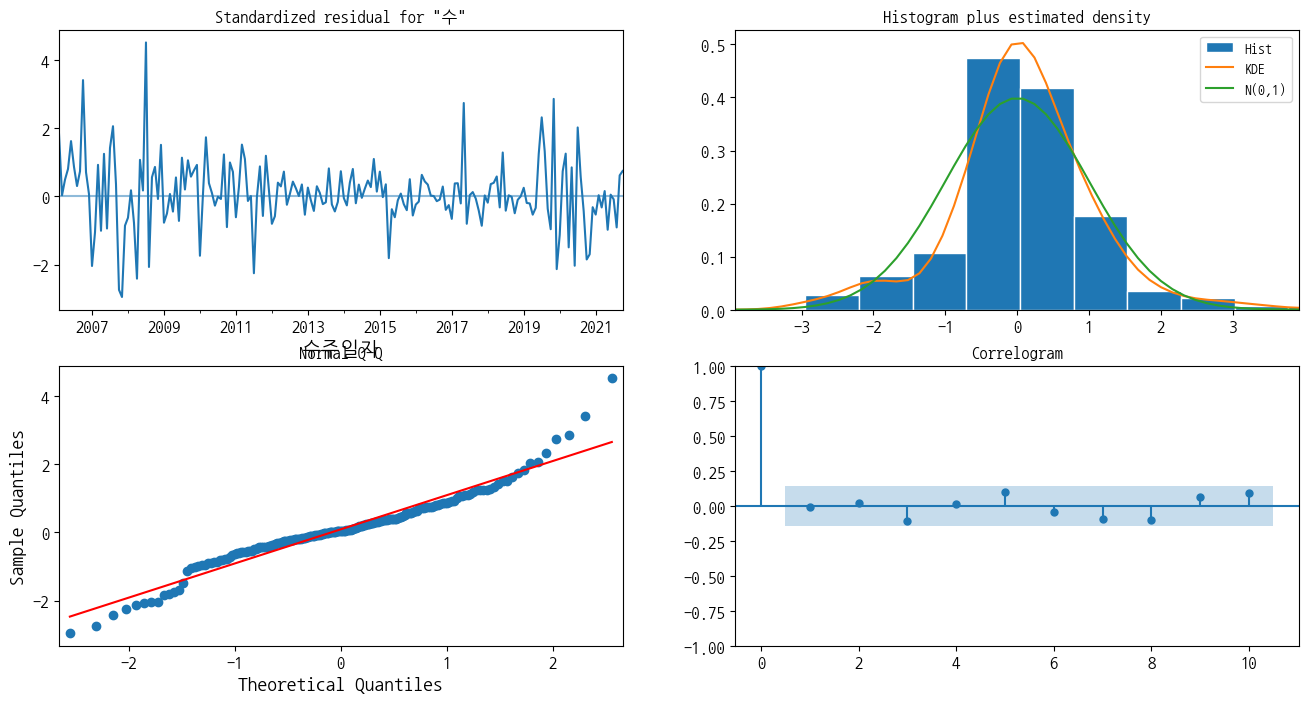

In [57]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [58]:
results.get_prediction()

In [59]:
y_source.head()

수주일자
2003-11-30    931.200000
2003-12-31    648.815789
2004-01-31    971.500000
2004-02-29    680.312500
2004-03-31    939.894737
Freq: M, Name: 수주수량KG, dtype: float64

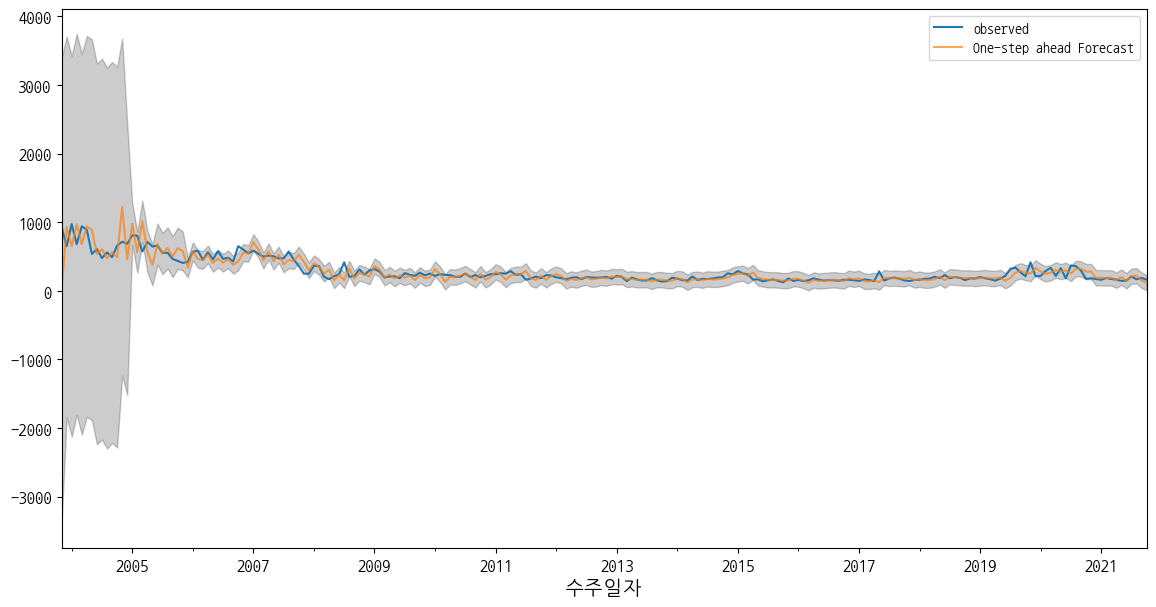

In [60]:
pred = results.get_prediction(start=pd.to_datetime('2003-11-30'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_source.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

In [61]:
pred = results.get_prediction(start=pd.to_datetime('2003-11-30'), dynamic=False)
pd.DataFrame(pred.predicted_mean).reset_index()

,수주일자,predicted_mean
0,2003-11-30,0.000000
1,2003-12-31,931.200000
2,2004-01-31,649.043010
3,2004-02-29,971.240638
4,2004-03-31,680.546503
...,...,...
211,2021-06-30,146.039798
212,2021-07-31,212.792369
213,2021-08-31,219.975793
214,2021-09-30,153.507820


In [63]:
y_forecasted = pred.predicted_mean
y_truth = y_source['2003-11-30':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

MSE 12983.75


In [46]:
np.sqrt(12983.75)

113.94625926286479

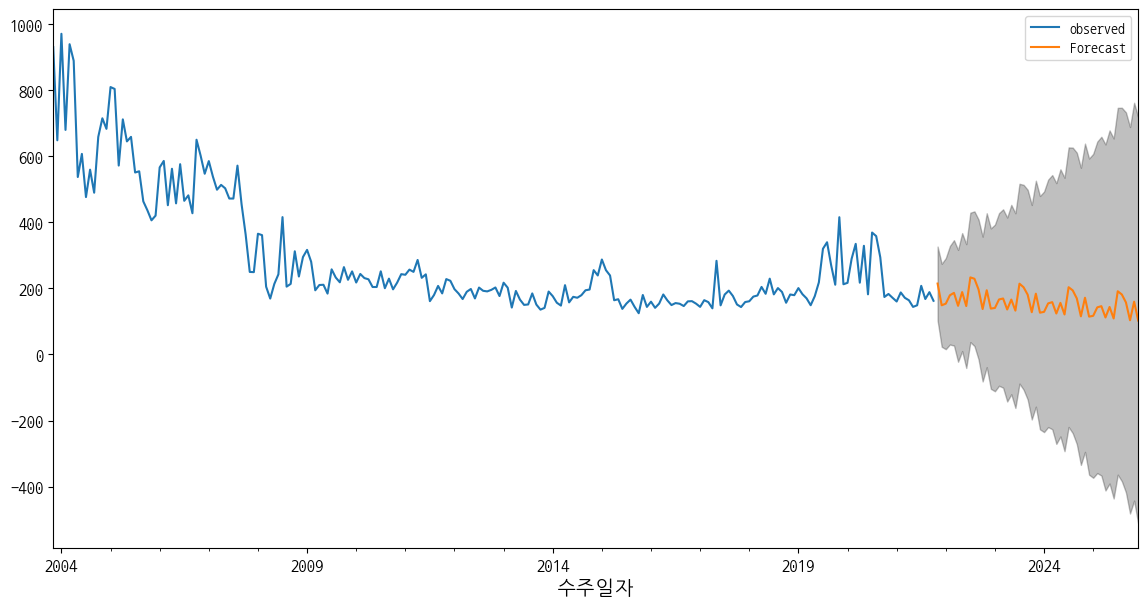

In [64]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int() #추정된 계수의 신뢰구간 계산
ax = y_source.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.25)

plt.legend()
plt.show()

### 샐러드

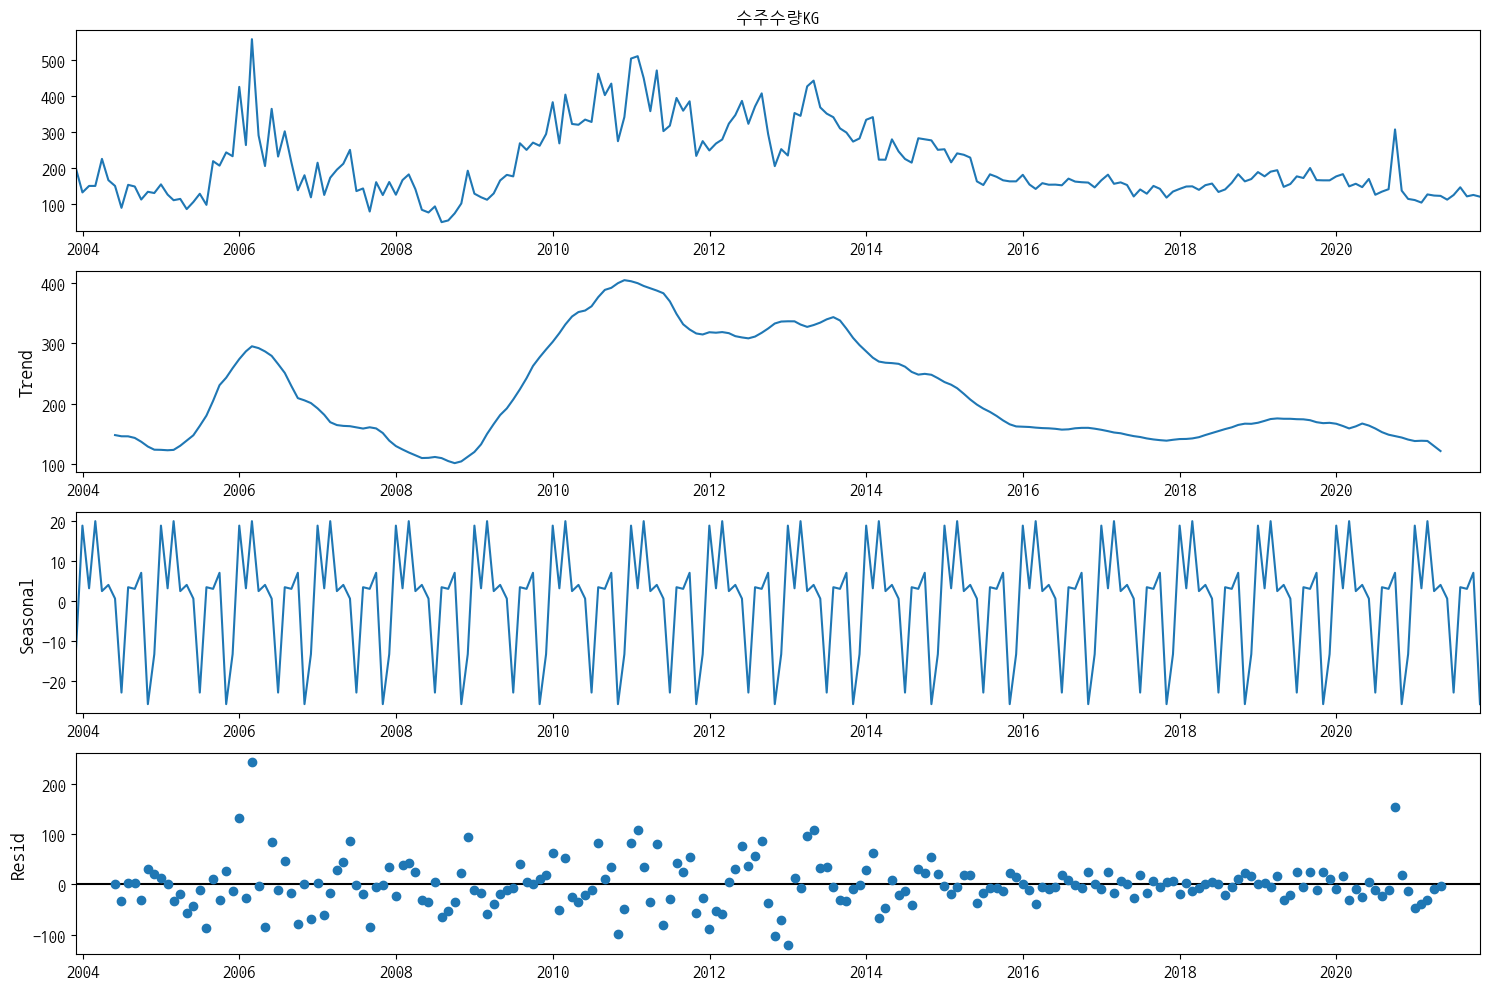

In [65]:
model_series = tsa.seasonal_decompose(y_salad, model='additive')
fig = model_series.plot()
plt.show()

In [66]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [67]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [68]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [69]:
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [70]:
param_list = []
param_seasonal_list = []
results_AIC_list = []

In [71]:
for param in pdq:
     for param_seasonal in seasonal_pdq:
        try:
            mod = tsa.statespace.SARIMAX(y_salad,order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            param_list.append(param)
            param_seasonal_list.append(param_seasonal)
            results_AIC_list.append(results.aic)
        except:
             continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.83827D+00    |proj g|=  5.21734D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   5.217D-06   6.838D+00
  F =   6.8382731647223727     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.2

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.69853D+00    |proj g|=  5.74816D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   1.252D-06   5.698D+00
  F =   5.6976735855359175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.3

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     17      1     0     0   8.958D-07   5.336D+00
  F =   5.3359465355188611     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.69899D+00    |proj g|=  2.61736D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate    5    f=  5.65765D+00    |proj g|=  2.53118D-02

At iterate   10    f=  5.65758D+00    |proj g|=  1.78986D-02

At iterate   15    f=  5.65583D+00    |proj g|=  1.86282D-01

At iterate   20    f=  5.64858D+00    |proj g|=  1.49004D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     26      1     0     0   4.074D-06   5.649D+00
  F =   5.6485689304835986     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.35782D+00    |proj g|=  1.31439D-01

At iterate    5    f=  5.32492D+00    |proj g|=  2.95412D-02

At iterate   10    f=  5.32000D+00    |proj g|=  1.05235D-02

At iterate   15    f=  5.31994D+00    |proj g|=  5.93796D-04

At iterate   20    f=  5.31973D+00    |proj g|=  1.30193D-02

At iterate   25    f=  5.31947D+00    |proj g|=  1.12253D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     35      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.07065D+00    |proj g|=  3.13256D-03

At iterate   10    f=  6.06369D+00    |proj g|=  1.15003D-01

At iterate   15    f=  5.76600D+00    |proj g|=  3.62823D-01

At iterate   20    f=  5.71765D+00    |proj g|=  1.19922D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     28      1     0     0   2.481D-05   5.718D+00
  F =   5.7176447911686861     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.52203D+00    |proj g|=  2.03409D-03

At iterate    5    f=  5.50938D+00    |proj g|=  6.71305D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   5.294D-08   5.509D+00
  F =   5.5093826308933718     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  6.07366D+00    |proj g|=  3.79811D-02

At iterate   10    f=  5.90441D+00    |proj g|=  7.05295D-01

At iterate   15    f=  5.52523D+00    |proj g|=  1.40825D-02

At iterate   20    f=  5.52474D+00    |proj g|=  8.26068D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     25      1     0     0   8.261D-06   5.525D+00
  F =   5.5247401336593036     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  6.01369D+00    |proj g|=  3.53424D-03

At iterate   10    f=  6.00457D+00    |proj g|=  4.53889D-02

At iterate   15    f=  5.58016D+00    |proj g|=  3.50714D-01

At iterate   20    f=  5.43098D+00    |proj g|=  1.52367D-01

At iterate   25    f=  5.42343D+00    |proj g|=  1.14469D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     33      1     0     0   2.001D-06   5.423D+00
  F =   5.4234306406649218     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.21639D+00    |proj g|=  8.92144D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   1.550D-06   5.213D+00
  F =   5.2126117410140482     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.15547D+00    |proj g|=  1.16558D-01

At iterate    5    f=  5.13622D+00    |proj g|=  3.14659D-03

At iterate   10    f=  5.13465D+00    |proj g|=  2.16969D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.45413D+00    |proj g|=  7.33766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      3      4      1     0     0   1.294D-06   5.453D+00
  F =   5.4532509793582449     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.9

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  5.18877D+00    |proj g|=  2.22881D-02

At iterate   10    f=  5.18397D+00    |proj g|=  5.09802D-03

At iterate   15    f=  5.18178D+00    |proj g|=  9.43086D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     31      1     0     0   1.415D-05   5.182D+00
  F =   5.1817524607541694     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.07771D+00    |proj g|=  5.36291D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.363D-06   5.078D+00
  F =   5.0777090981673965     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.9

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.05084D+00    |proj g|=  9.32839D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     15      1     0     0   4.520D-06   5.051D+00
  F =   5.0508398061266702     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33449D+00    |proj g|=  4.42194D-03

At iterate    5    f=  5.33448D+00    |proj g|=  2.66199D-03

At iterate   10    f=  5.33444D+00    |proj g|=  1.14126D-04

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.86259D+00    |proj g|=  1.38103D-01

At iterate    5    f=  4.84344D+00    |proj g|=  5.17180D-03

At iterate   10    f=  4.83297D+00    |proj g|=  1.28771D-01

At iterate   15    f=  4.77764D+00    |proj g|=  3.08253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     21      1     0     0   1.004D-06   4.777D+00
  F =   4.7770315459334673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.04454D+00    |proj g|=  8.27746D-02

At iterate   10    f=  5.04070D+00    |proj g|=  1.06660D-03

At iterate   15    f=  5.04054D+00    |proj g|=  1.47074D-02

At iterate   20    f=  5.03970D+00    |proj g|=  1.30778D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     37      1     0     0   3.680D-07   5.040D+00
  F =   5.0396961214812181     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  4.97090D+00    |proj g|=  6.94778D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   7.762D-06   4.968D+00
  F =   4.9682711950549088     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.87620D+00    |proj g|=  1.26565D-01


 This problem is unconstrained.



At iterate    5    f=  4.84355D+00    |proj g|=  2.69919D-02

At iterate   10    f=  4.84232D+00    |proj g|=  2.90788D-02

At iterate   15    f=  4.78431D+00    |proj g|=  1.28943D-01

At iterate   20    f=  4.77703D+00    |proj g|=  3.21135D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   8.437D-06   4.777D+00
  F =   4.7770260586810833     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.29391D+00    |proj g|=  5.92831D-01

At iterate    5    f=  5.19640D+00    |proj g|=  1.46824D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   7.115D-05   5.196D+00
  F =   5.1963880600303902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at th

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.94737D+00    |proj g|=  3.93901D-03

At iterate   10    f=  4.94262D+00    |proj g|=  7.02834D-02

At iterate   15    f=  4.91311D+00    |proj g|=  2.94412D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   8.979D-07   4.913D+00
  F =   4.9127920892120374     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.48041D+00    |proj g|=  7.50066D-01

At iterate    5    f=  5.19669D+00    |proj g|=  7.18438D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   9.223D-05   5.196D+00
  F =   5.1964434956178600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterat

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.02090D+00    |proj g|=  7.40300D-03

At iterate   10    f=  5.01666D+00    |proj g|=  9.02309D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   4.817D-06   5.017D+00
  F =   5.0165985232951709     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02542D+00    |proj g|=  2.44996D-01

At iterate    5    f=  4.94686D+00    |proj g|=  2.99814D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.07280D+00    |proj g|=  1.68430D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   2.418D-04   5.073D+00
  F =   5.0727447954922864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33356D+00    |proj g|=  3.76894D-02

At iterate    5    f=  5.33282D+00    |proj g|=  1.28287D-04

At iterate   10    f=  5.33281D+00    |proj g|=  2.78616D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   2.658D-06   5.333D+00
  F =   5.3327952934682123     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.93866D+00    |proj g|=  2.66211D-01

At iterate    5    f=  4.85076D+00    |proj g|=  5.08258D-03

At iterate   10    f=  4.84514D+00    |proj g|=  6.64081D-02

At iterate   15    f=  4.79382D+00    |proj g|=  5.73955D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.10387D+00    |proj g|=  9.78068D-02

At iterate   10    f=  5.09591D+00    |proj g|=  1.24249D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   1.896D-04   5.096D+00
  F =   5.0959094346631773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.18818D+00    |proj g|=  5.25300D-01

At iterate    5    f=  5.07034D+00    |proj g|=  3.44207D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  4.96289D+00    |proj g|=  4.56841D-03

At iterate   10    f=  4.96237D+00    |proj g|=  4.92051D-02

At iterate   15    f=  4.95364D+00    |proj g|=  1.45376D-02

At iterate   20    f=  4.95350D+00    |proj g|=  6.44249D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     23      1     0     0   6.442D-06   4.954D+00
  F =   4.9535024549240099     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  4.85282D+00    |proj g|=  6.30405D-02

At iterate   10    f=  4.85064D+00    |proj g|=  5.08393D-03

At iterate   15    f=  4.84727D+00    |proj g|=  7.58111D-02

At iterate   20    f=  4.79518D+00    |proj g|=  6.66815D-02

At iterate   25    f=  4.79197D+00    |proj g|=  2.75391D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     35      1     0     0   1.178D-05   4.792D+00
  F =   4.7919691446359183     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.08300D+00    |proj g|=  2.18876D-03

At iterate   10    f=  5.08289D+00    |proj g|=  2.97770D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   2.432D-06   5.083D+00
  F =   5.0828866116681404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36632D+00    |proj g|=  5.55493D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  4.87475D+00    |proj g|=  5.02216D-03

At iterate   10    f=  4.86337D+00    |proj g|=  1.27529D-01

At iterate   15    f=  4.81420D+00    |proj g|=  1.97045D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   9.209D-06   4.814D+00
  F =   4.8138837223858220     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.08341D+00    |proj g|=  3.59123D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.08260D+00    |proj g|=  9.80937D-03

At iterate   10    f=  5.07779D+00    |proj g|=  6.54627D-02

At iterate   15    f=  5.07642D+00    |proj g|=  6.16521D-04

At iterate   20    f=  5.07624D+00    |proj g|=  1.04228D-02

At iterate   25    f=  5.07609D+00    |proj g|=  1.46291D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     38      1     0     0   4.046D-06   5.076D+00
  F =   5.0760916755117806     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate   10    f=  4.92189D+00    |proj g|=  5.29840D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     17      1     0     0   5.479D-06   4.920D+00
  F =   4.9203477457680851     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.90149D+00    |proj g|=  1.28336D-01


 This problem is unconstrained.



At iterate    5    f=  4.87466D+00    |proj g|=  1.23226D-02

At iterate   10    f=  4.87274D+00    |proj g|=  2.80798D-02

At iterate   15    f=  4.81580D+00    |proj g|=  3.86328D-02

At iterate   20    f=  4.81387D+00    |proj g|=  3.16164D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     27      1     0     0   4.420D-06   4.814D+00
  F =   4.8138727526518643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.05017D+00    |proj g|=  4.41078D-03

At iterate   10    f=  5.05015D+00    |proj g|=  1.53266D-03

At iterate   15    f=  5.05009D+00    |proj g|=  1.23810D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   8.663D-06   5.050D+00
  F =   5.0500899706205438     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.33444D+00    |proj g|=  1.50369D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   9.072D-05   5.334D+00
  F =   5.3337819552492034     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.86209D+00    |proj g|=  1.37432D-01

At iterate    5    f=  4.84269D+00    |proj g|=  7.24023D-03

At iterate   10    f=  4.84066D+00    |proj g|=  6.41727D-03

At iterate   15    f=  4.81748D+00    |proj g|=  1.28546D-01

At iter

 This problem is unconstrained.



At iterate    5    f=  5.07314D+00    |proj g|=  3.78449D-03

At iterate   10    f=  5.07312D+00    |proj g|=  2.20446D-03

At iterate   15    f=  5.07309D+00    |proj g|=  9.85130D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   1.479D-05   5.073D+00
  F =   5.0730916362133645     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.05274D+00    |proj g|=  5.61381D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  5.04368D+00    |proj g|=  3.04025D-02

At iterate   20    f=  5.04256D+00    |proj g|=  2.56921D-03

At iterate   25    f=  5.04086D+00    |proj g|=  3.98510D-02

At iterate   30    f=  5.03968D+00    |proj g|=  4.03054D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     45      1     0     0   3.190D-05   5.040D+00
  F =   5.0396842874020811     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  4.91969D+00    |proj g|=  2.31323D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   1.344D-05   4.919D+00
  F =   4.9192209086460785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.87339D+00    |proj g|=  1.27179D-01


 This problem is unconstrained.



At iterate    5    f=  4.84314D+00    |proj g|=  7.02824D-03

At iterate   10    f=  4.84114D+00    |proj g|=  1.97307D-02

At iterate   15    f=  4.83510D+00    |proj g|=  9.16656D-02

At iterate   20    f=  4.77741D+00    |proj g|=  2.56355D-02

At iterate   25    f=  4.77694D+00    |proj g|=  1.76792D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     33      1     0     0   1.654D-07   4.777D+00
  F =   4.7769403728562807     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [72]:
ARIMA_list = pd.DataFrame({'Parameter':param_list,'Seasonal':param_seasonal_list,'AIC':results_AIC_list})

In [73]:
ARIMA_list.sort_values(by='AIC')

,Parameter,Seasonal,AIC
27,"(0, 1, 1)","(0, 1, 1, 12)",2069.677628
59,"(1, 1, 1)","(0, 1, 1, 12)",2071.640296
31,"(0, 1, 1)","(1, 1, 1, 12)",2071.675257
63,"(1, 1, 1)","(1, 1, 1, 12)",2073.638241
43,"(1, 0, 1)","(0, 1, 1, 12)",2078.170552
...,...,...,...
4,"(0, 0, 0)","(1, 0, 0, 12)",2465.964399
9,"(0, 0, 1)","(0, 0, 1, 12)",2476.022550
1,"(0, 0, 0)","(0, 0, 1, 12)",2630.239160
8,"(0, 0, 1)","(0, 0, 0, 12)",2740.664521


In [74]:
mod = tsa.statespace.SARIMAX(y_salad,order=(0, 1, 1),seasonal_order=(0, 1, 1, 12),
                              enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.86259D+00    |proj g|=  1.38103D-01

At iterate    5    f=  4.84344D+00    |proj g|=  5.17180D-03

At iterate   10    f=  4.83297D+00    |proj g|=  1.28771D-01


 This problem is unconstrained.



At iterate   15    f=  4.77764D+00    |proj g|=  3.08253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     21      1     0     0   1.004D-06   4.777D+00
  F =   4.7770315459334673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:                             수주수량KG   No. Observations:                  216
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1031.839
Date:                            Mon, 13 Mar 2023   AIC                           2069.6

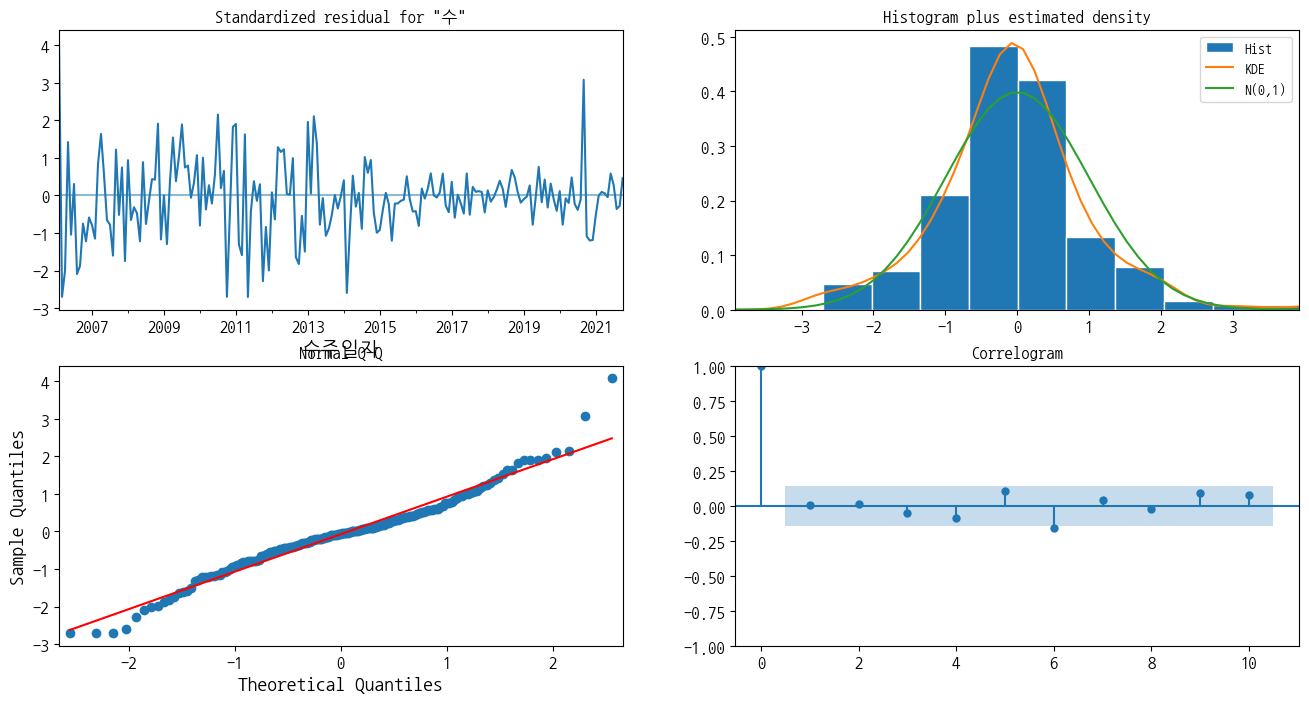

In [75]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [76]:
y_salad.head()

수주일자
2003-11-30    200.0
2003-12-31    132.0
2004-01-31    150.0
2004-02-29    150.0
2004-03-31    225.0
Freq: M, Name: 수주수량KG, dtype: float64

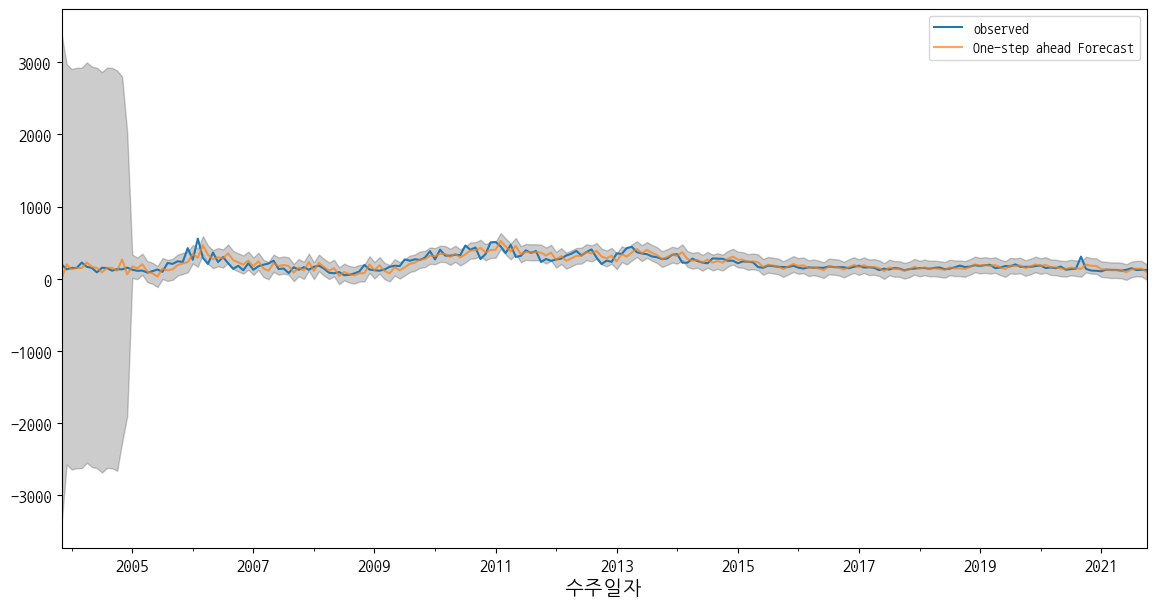

In [78]:
pred = results.get_prediction(start=pd.to_datetime('2003-11-30'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_salad.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

In [79]:
pred = results.get_prediction(start=pd.to_datetime('2003-11-30'), dynamic=False)
pd.DataFrame(pred.predicted_mean).reset_index()

,수주일자,predicted_mean
0,2003-11-30,0.000000
1,2003-12-31,200.000000
2,2004-01-31,132.043288
3,2004-02-29,149.988573
4,2004-03-31,149.999993
...,...,...
211,2021-06-30,92.799315
212,2021-07-31,130.891594
213,2021-08-31,140.876788
214,2021-09-30,140.048201


In [80]:
y_forecasted = pred.predicted_mean
y_truth = y_salad['2003-11-30':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

MSE 3842.48


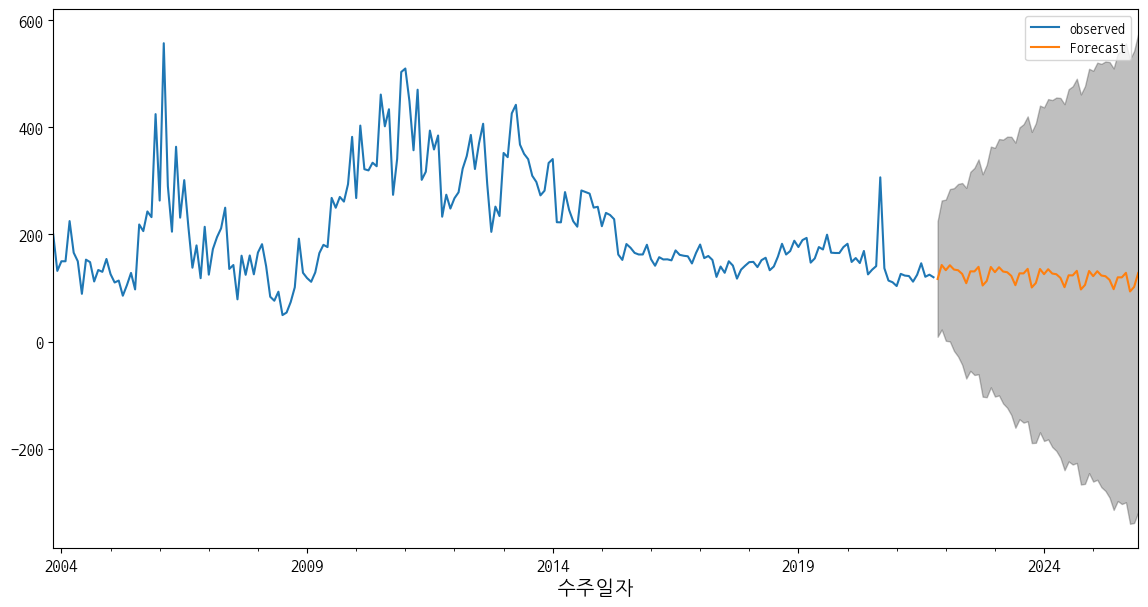

In [81]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int() #추정된 계수의 신뢰구간 계산
ax = y_salad.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.25)

plt.legend()
plt.show()

### 볶음밥

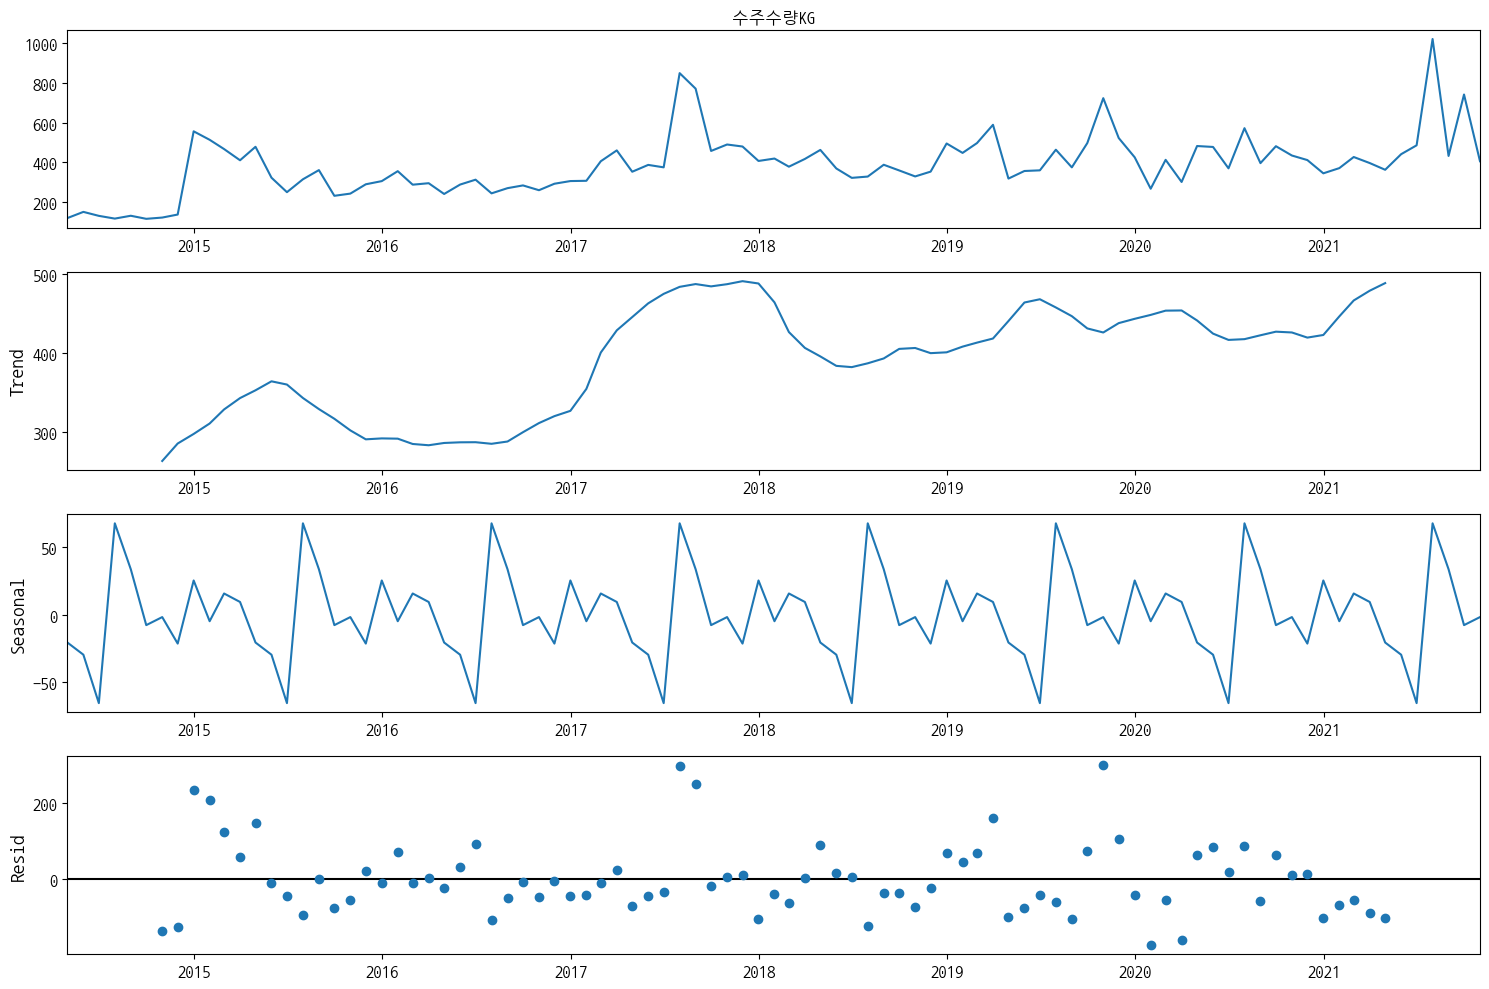

In [82]:
model_series = tsa.seasonal_decompose(y_Frice, model='additive')
fig = model_series.plot()
plt.show()

In [83]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [84]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [85]:
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [86]:
param_list = []
param_seasonal_list = []
results_AIC_list = []

In [89]:
for param in pdq:
     for param_seasonal in seasonal_pdq:
        try:
            mod = tsa.statespace.SARIMAX(y_Frice,order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            param_list.append(param)
            param_seasonal_list.append(param_seasonal)
            results_AIC_list.append(results.aic)
        except:
             continue

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.37184D+00    |proj g|=  2.42384D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   1.583D-07   7.372D+00
  F =   7.3718190650475828     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.5

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate    5    f=  5.58960D+00    |proj g|=  6.49015D-01

At iterate   10    f=  5.57234D+00    |proj g|=  9.04577D-04

At iterate   15    f=  5.57228D+00    |proj g|=  3.36217D-02

At iterate   20    f=  5.56774D+00    |proj g|=  2.37817D-01

At iterate   25    f=  5.56381D+00    |proj g|=  1.41330D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     28      1     0     0   1.961D-07   5.564D+00
  F =   5.5638103078383967     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.70849D+00    |proj g|=  2.24073D-02

At iterate   15    f=  4.69977D+00    |proj g|=  2.17270D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     22      1     0     0   5.406D-06   4.699D+00
  F =   4.6993599886569415     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.02886D+00    |proj g|=  1.49461D-01

At iterate    5    f=  7.01561D+00    |proj g|=  1.32319D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   20    f=  6.88525D+00    |proj g|=  2.40909D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     23      1     0     0   4.200D-06   6.885D+00
  F =   6.8852477238548984     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.13679D+00    |proj g|=  4.25091D-01

At iterate    5    f=  6.02954D+00    |proj g|=  1.37524D-03

At iterate   10    f=  6.02891D+00    |proj g|=  2.54528D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.59368D+00    |proj g|=  2.87856D-02

At iterate   15    f=  4.58491D+00    |proj g|=  5.16596D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     20      1     0     0   1.166D-06   4.585D+00
  F =   4.5848356383931064     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.10792D+00    |proj g|=  6.07766D-02

At iterate    5    f=  6.10270D+00    |proj g|=  2.36636D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  5.66184D+00    |proj g|=  1.96710D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     31      1     0     0   7.810D-06   5.662D+00
  F =   5.6618131738076292     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07847D+00    |proj g|=  4.05239D-01

At iterate    5    f=  5.94109D+00    |proj g|=  2.44374D-03

At iterate   10    f=  5.94061D+00    |proj g|=  1.09133D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.59051D+00    |proj g|=  1.33992D-01

At iterate    5    f=  4.58117D+00    |proj g|=  6.78900D-03

At iterate   10    f=  4.58107D+00    |proj g|=  4.81621D-03

At iterate   15    f=  4.57648D+00    |proj g|=  4.94313D-02

At iterate   20    f=  4.56821D+00    |proj g|=  2.14719D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     28      1     0     0   1.595D-06   4.568D+00
  F =   4.5679056533759645     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.66753D+00    |proj g|=  4.73863D-02

At iterate    5    f=  4.66556D+00    |proj g|=  3.59922D-03

At iterate   10    f=  4.66239D+00    |proj g|=  5.43642D-02

At iterate   15    f=  4.65156D+00    |proj g|=  2.67081D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     18      1     0     0   8.766D-08   4.652D+00
  F =   4.6515553657632021     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.44135D+00    |proj g|=  1.71604D-02

At iterate   15    f=  5.43269D+00    |proj g|=  9.31959D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   3.043D-06   5.433D+00
  F =   5.4326853728961328     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.71637D+00    |proj g|=  4.14984D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.23041D+00    |proj g|=  2.55723D-02

At iterate   15    f=  5.22726D+00    |proj g|=  7.98984D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     19      1     0     0   8.870D-07   5.227D+00
  F =   5.2272603063015692     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.47477D+00    |proj g|=  5.49754D-02

At iterate    5    f=  5.47191D+00    |proj g|=  1.74180D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.52085D+00    |proj g|=  6.12619D-02

At iterate   15    f=  4.51675D+00    |proj g|=  9.36780D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   9.368D-06   4.517D+00
  F =   4.5167509512329831     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.38842D+00    |proj g|=  1.07484D-01

At iterate    5    f=  5.37046D+00    |proj g|=  7.86592D-04

At iter

 This problem is unconstrained.



At iterate    5    f=  5.23098D+00    |proj g|=  7.96265D-04

At iterate   10    f=  5.23075D+00    |proj g|=  1.12458D-02

At iterate   15    f=  5.22731D+00    |proj g|=  6.61755D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   3.745D-07   5.227D+00
  F =   5.2271777864791851     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.68081D+00    |proj g|=  3.55436D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.67368D+00    |proj g|=  3.36846D-02

At iterate   15    f=  4.66584D+00    |proj g|=  1.03602D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   6.489D-06   4.666D+00
  F =   4.6658387751268338     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.53759D+00    |proj g|=  4.21341D-02

At iterate    5    f=  4.52151D+00    |proj g|=  1.26254D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.48908D+00    |proj g|=  1.12276D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   1.123D-04   5.489D+00
  F =   5.4890805189987217     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.54285D+00    |proj g|=  6.21032D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.46449D+00    |proj g|=  1.54238D-01

At iterate   10    f=  5.45025D+00    |proj g|=  7.00352D-04

At iterate   15    f=  5.44994D+00    |proj g|=  2.40586D-02

At iterate   20    f=  5.44702D+00    |proj g|=  1.99586D-02

At iterate   25    f=  5.44684D+00    |proj g|=  1.40590D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   1.406D-06   5.447D+00
  F =   5.4468446633732794     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.61337D+00    |proj g|=  1.03135D-03

At iterate   10    f=  4.61233D+00    |proj g|=  1.12175D-02

At iterate   15    f=  4.60274D+00    |proj g|=  4.53725D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     23      1     0     0   1.654D-06   4.603D+00
  F =   4.6026560139774944     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15716D+00    |proj g|=  6.96338D-02

At iterate    5    f=  6.15255D+00    |proj g|=  1.15042D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   5.234D-04   6.152D+00
  F =   6.1523926028371108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.55539D+00    |proj g|=  1.33536D-03

At iterate   10    f=  4.55523D+00    |proj g|=  1.03747D-02

At iterate   15    f=  4.54703D+00    |proj g|=  4.84434D-02

At iterate   20    f=  4.54480D+00    |proj g|=  2.55994D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   1.819D-06   4.545D+00
  F =   4.5447985227362464     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.46069D+00    |proj g|=  3.87847D-01

At iterate    5    f=  5.40735D+00    |proj g|=  8.54798D-02

At iterate   10    f=  5.37639D+00    |proj g|=  2.41149D-02

At iterate   15    f=  5.37549D+00    |proj g|=  1.54852D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   7.881D-06   5.375D+00
  F =   5.3754930478334488     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.61817D+00    |proj g|=  1.11047D-03

At iterate   10    f=  4.61662D+00    |proj g|=  3.70835D-02

At iterate   15    f=  4.60737D+00    |proj g|=  6.79894D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   1.582D-05   4.607D+00
  F =   4.6073455953529097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.54997D+00    |proj g|=  2.02497D-02


 This problem is unconstrained.



At iterate    5    f=  4.54504D+00    |proj g|=  4.50318D-03

At iterate   10    f=  4.54469D+00    |proj g|=  3.41886D-03

At iterate   15    f=  4.53190D+00    |proj g|=  2.31428D-02

At iterate   20    f=  4.53107D+00    |proj g|=  1.54124D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   9.609D-07   4.531D+00
  F =   4.5310691960803720     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.56267D+00    |proj g|=  4.49258D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.493D-06   5.563D+00
  F =   5.5626718695020099     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.6

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  5.33069D+00    |proj g|=  4.08024D-03

At iterate   20    f=  5.33066D+00    |proj g|=  1.05995D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     25      1     0     0   5.270D-06   5.331D+00
  F =   5.3306603903331942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.62093D+00    |proj g|=  3.02368D-02

At iterate    5    f=  4.61967D+00    |proj g|=  1.73706D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.61083D+00    |proj g|=  8.88007D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     18      1     0     0   1.397D-06   4.611D+00
  F =   4.6107516403925590     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61473D+00    |proj g|=  4.47098D-02

At iterate    5    f=  4.60336D+00    |proj g|=  1.18470D-03

At iterate   10    f=  4.60032D+00    |proj g|=  3.94543D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  6.06889D+00    |proj g|=  2.91176D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     33      1     0     0   3.007D-05   6.069D+00
  F =   6.0688883412749322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25863D+00    |proj g|=  1.05840D-01

At iterate    5    f=  5.23391D+00    |proj g|=  8.08814D-02

At iterate   10    f=  5.22657D+00    |proj g|=  2.16428D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     27      1     0     0   2.942D-06   5.433D+00
  F =   5.4334916149828709     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.52617D+00    |proj g|=  1.10367D-01

At iterate    5    f=  4.50870D+00    |proj g|=  5.32689D-03

At iterate   10    f=  4.50864D+00    |proj g|=  1.26858D-02

At iterate   15    f=  4.50344D+00    |proj g|=  7.45889D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  5.29932D+00    |proj g|=  7.22451D-02

At iterate   10    f=  5.29360D+00    |proj g|=  8.69828D-04

At iterate   15    f=  5.29335D+00    |proj g|=  8.04715D-03

At iterate   20    f=  5.28962D+00    |proj g|=  4.06473D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     31      1     0     0   2.220D-06   5.289D+00
  F =   5.2891314814655379     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.31499D+00    |proj g|=  1.95932D-01

At iterate    5    f=  5.23070D+00    |proj g|=  2.50953D-02

At iterate   10    f=  5.22656D+00    |proj g|=  8.16164D-04

At iterate   15    f=  5.22625D+00    |proj g|=  1.57266D-02

At iterate   20    f=  5.22268D+00    |proj g|=  8.33905D-03

At iterate   25    f=  5.22259D+00    |proj g|=  8.42235D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  4.57421D+00    |proj g|=  2.10242D-02

At iterate   10    f=  4.57376D+00    |proj g|=  3.88362D-03

At iterate   15    f=  4.57254D+00    |proj g|=  5.98166D-02

At iterate   20    f=  4.55152D+00    |proj g|=  6.41350D-02

At iterate   25    f=  4.54678D+00    |proj g|=  7.69752D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     35      1     0     0   2.441D-05   4.547D+00
  F =   4.5467780700639793     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  4.50013D+00    |proj g|=  6.98989D-03

At iterate   10    f=  4.49962D+00    |proj g|=  1.46594D-03

At iterate   15    f=  4.49847D+00    |proj g|=  2.67784D-02

At iterate   20    f=  4.47244D+00    |proj g|=  9.40161D-02

At iterate   25    f=  4.46773D+00    |proj g|=  1.82946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   4.834D-06   4.468D+00
  F =   4.4677317167076964     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [90]:
ARIMA_list = pd.DataFrame({'Parameter':param_list,'Seasonal':param_seasonal_list,'AIC':results_AIC_list})

In [91]:
ARIMA_list.sort_values(by='AIC')

,Parameter,Seasonal,AIC
63,"(1, 1, 1)","(1, 1, 1, 12)",823.127172
59,"(1, 1, 1)","(0, 1, 1, 12)",823.648964
31,"(0, 1, 1)","(1, 1, 1, 12)",826.778019
27,"(0, 1, 1)","(0, 1, 1, 12)",828.048673
47,"(1, 0, 1)","(1, 1, 1, 12)",834.654594
...,...,...,...
1,"(0, 0, 0)","(0, 0, 1, 12)",1128.386004
16,"(0, 1, 0)","(0, 0, 0, 12)",1143.352583
32,"(1, 0, 0)","(0, 0, 0, 12)",1154.803503
8,"(0, 0, 1)","(0, 0, 0, 12)",1257.115086


In [92]:
mod = tsa.statespace.SARIMAX(y_Frice,order=(1, 1, 1),seasonal_order=(1, 1, 1, 12),
                              enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.52016D+00    |proj g|=  1.17108D-01

At iterate    5    f=  4.50013D+00    |proj g|=  6.98989D-03

At iterate   10    f=  4.49962D+00    |proj g|=  1.46594D-03

At iterate   15    f=  4.49847D+00    |proj g|=  2.67784D-02

At iterate   20    f=  4.47244D+00    |proj g|=  9.40161D-02

At iterate   25    f=  4.46773D+00    |proj g|=  1.82946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   

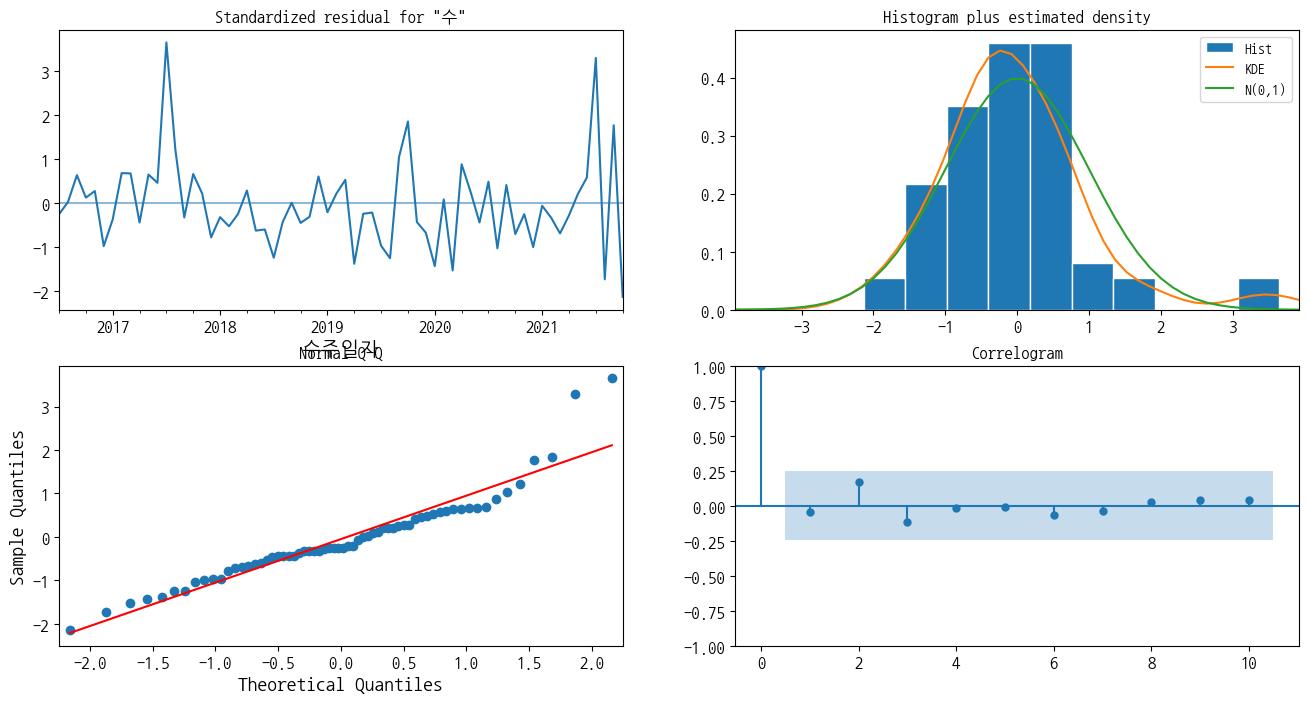

In [93]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [94]:
results.get_prediction()

In [95]:
y_Frice.head()

수주일자
2014-04-30    119.959091
2014-05-31    151.069318
2014-06-30    131.086827
2014-07-31    117.287646
2014-08-31    131.617538
Freq: M, Name: 수주수량KG, dtype: float64

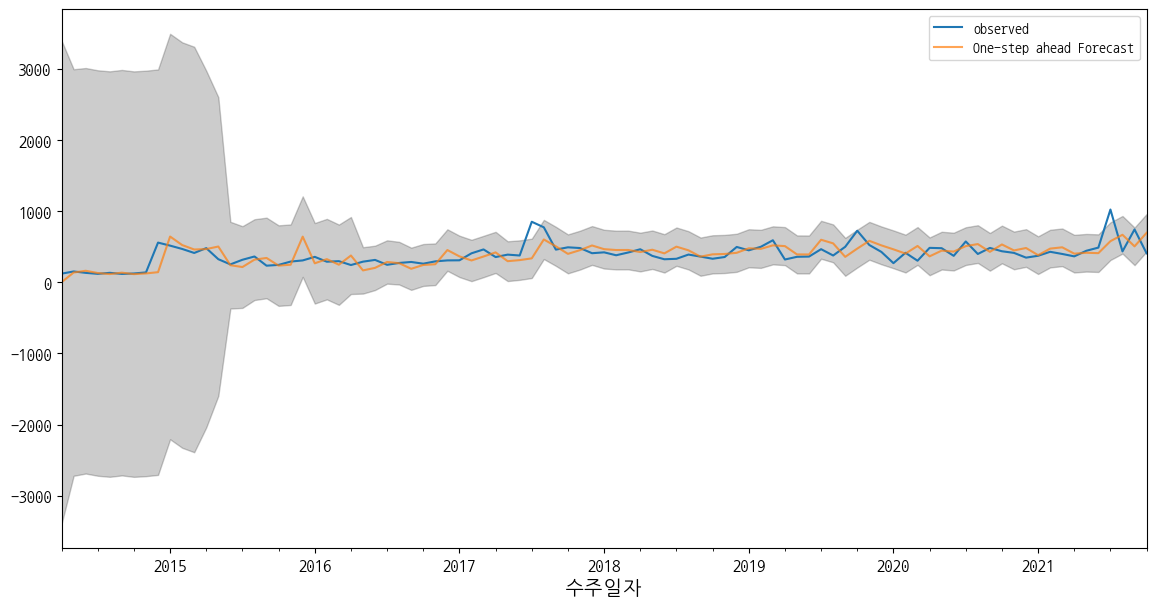

In [97]:
pred = results.get_prediction(start=pd.to_datetime('2014-04-30'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_Frice.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

In [98]:
pred = results.get_prediction(start=pd.to_datetime('2014-04-30'), dynamic=False)
pd.DataFrame(pred.predicted_mean).reset_index()

,수주일자,predicted_mean
0,2014-04-30,0.000000
1,2014-05-31,135.936960
2,2014-06-30,160.527001
3,2014-07-31,128.917044
4,2014-08-31,114.071174
...,...,...
86,2021-06-30,408.019090
87,2021-07-31,576.401215
88,2021-08-31,666.295147
89,2021-09-30,503.677960


In [101]:
y_forecasted = pred.predicted_mean
y_truth = y_Frice['2014-04-30':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

MSE 18145.46


In [47]:
np.sqrt(18145.46)

134.70508527891587

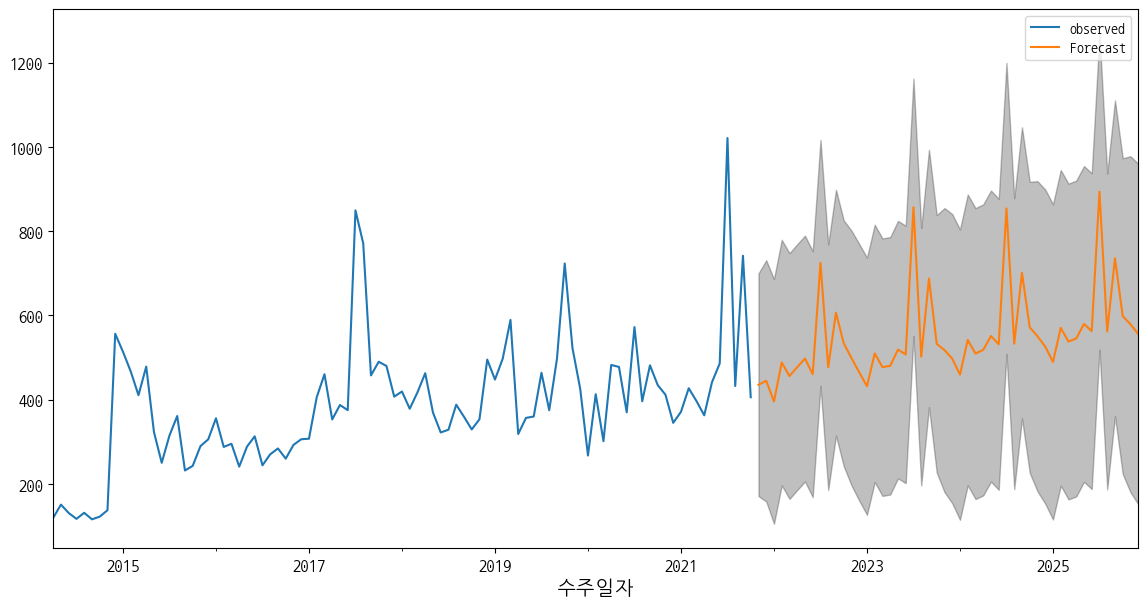

In [102]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int() #추정된 계수의 신뢰구간 계산
ax = y_Frice.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.25)

plt.legend()
plt.show()

### 드레싱

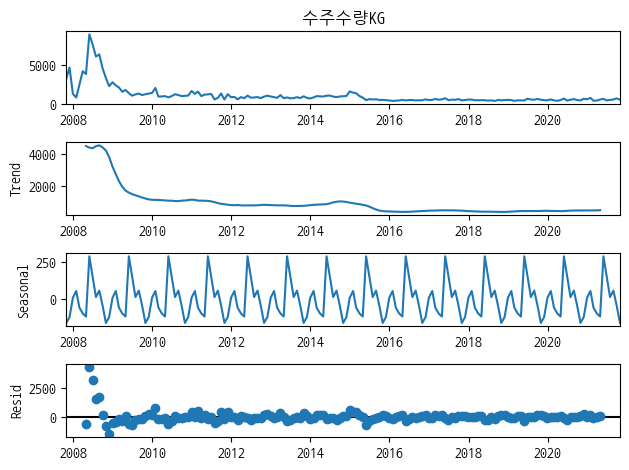

In [22]:
model_series = tsa.seasonal_decompose(y_dressing, model='additive')
fig = model_series.plot()
plt.show()

In [23]:
# p d q 그리드 서치 위한 리스트 선언
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [24]:
param_list = []
param_seasonal_list = []
results_AIC_list = []

In [25]:
for param in pdq:
     for param_seasonal in seasonal_pdq:
        try:
            mod = tsa.statespace.SARIMAX(y_dressing,order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            param_list.append(param)
            param_seasonal_list.append(param_seasonal)
            results_AIC_list.append(results.aic)
        except:
             continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74680D+00    |proj g|=  1.08134D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   7.086D-06   8.747D+00
  F =   8.7467574801626462     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.4

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82031D+00    |proj g|=  6.93166D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      4      1     0     0   5.242D-06   7.819D+00
  F =   7.8187974579035222     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.4

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  6.25341D+00    |proj g|=  4.54704D-01

At iterate   15    f=  6.23776D+00    |proj g|=  2.20336D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     23      1     0     0   3.720D-06   6.238D+00
  F =   6.2377615842044323     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.27556D+00    |proj g|=  3.49284D-05

           * * *

Tit   = total number of iterations
Tnf   = total num

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.44915D+00    |proj g|=  4.38036D+00

At iterate   10    f=  7.92434D+00    |proj g|=  1.55225D-02

At iterate   15    f=  7.88800D+00    |proj g|=  9.53159D-01

At iterate   20    f=  7.23577D+00    |proj g|=  3.74067D-02

At iterate   25    f=  7.20740D+00    |proj g|=  1.71946D-01

At iterate   30    f=  7.19540D+00    |proj g|=  1.99409D-02

At iterate   35    f=  7.19484D+00    |proj g|=  2.79961D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     50      1     0     0   7.385D-06   7.195D+00
  F =   7.1948334913279473     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73651D+00    |proj g|=  6.64815D+00

At iterate    5    f=  6.32489D+00    |proj g|=  1.01709D-01

At iterate   10    f=  6.32428D+00    |proj g|=  7.31837D-03

At iterate   15    f=  6.31459D+00    |proj g|=  4.62065D-01

At iterate   20    f=  6.23445D+00    |proj g|=  3.14786D-01

At iterate   25    f=  6.22861D+00    |proj g|=  8.24773D-02

At iterate   30    f=  6.22712D+00    |proj g|=  1.30247D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.57726D+00    |proj g|=  5.63204D-04

At iterate   10    f=  7.57322D+00    |proj g|=  4.09541D-02

At iterate   15    f=  7.26531D+00    |proj g|=  7.09182D-01

At iterate   20    f=  6.91417D+00    |proj g|=  5.98499D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     29      1     0     0   1.138D-05   6.914D+00
  F =   6.9141469623037182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71156D+00    |proj g|=  1.23431D-01

At iterate    5    f=  6.67345D+00    |proj g|=  6.22251D-03

At iterate   10    f=  6.67338D+00    |proj g|=  2.62708D-03

At iterate   15    f=  6.66760D+00    |proj g|=  4.43951D-02

At iterate   20    f=  6.11639D+00    |proj g|=  1.65406D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     30      1     0     0   4.857D-06   6.114D+00
  F =   6.1139880537810845     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  7.67256D+00    |proj g|=  5.68778D-04

At iterate   10    f=  7.67245D+00    |proj g|=  6.68195D-03

At iterate   15    f=  7.65957D+00    |proj g|=  7.86434D-02

At iterate   20    f=  7.30163D+00    |proj g|=  8.92849D-01

At iterate   25    f=  7.05408D+00    |proj g|=  3.73111D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     40      1     0     0   3.430D-06   7.054D+00
  F =   7.0540732373570982     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  7.56809D+00    |proj g|=  7.13613D-03

At iterate   10    f=  7.56783D+00    |proj g|=  9.52076D-04

At iterate   15    f=  7.56750D+00    |proj g|=  1.92618D-02

At iterate   20    f=  7.54282D+00    |proj g|=  1.32457D-01

At iterate   25    f=  7.46029D+00    |proj g|=  2.99564D-01

At iterate   30    f=  7.10685D+00    |proj g|=  5.30017D-01

At iterate   35    f=  6.90382D+00    |proj g|=  5.65769D-02

At iterate   40    f=  6.90269D+00    |proj g|=  2.20158D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     59      1     0     0   5.160D-06   6.903D+00
  F =   6.90268589986

 This problem is unconstrained.



At iterate   15    f=  6.68435D+00    |proj g|=  5.01462D-01

At iterate   20    f=  6.27831D+00    |proj g|=  2.39068D-01

At iterate   25    f=  6.25062D+00    |proj g|=  3.89092D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     33      1     0     0   3.351D-07   6.251D+00
  F =   6.2506157157284958     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72070D+00    |proj g|=  1.49675D-01


 This problem is unconstrained.



At iterate    5    f=  6.67343D+00    |proj g|=  1.83893D-03

At iterate   10    f=  6.67327D+00    |proj g|=  1.77836D-03

At iterate   15    f=  6.67232D+00    |proj g|=  3.68457D-02

At iterate   20    f=  6.63327D+00    |proj g|=  1.81624D-01

At iterate   25    f=  6.15158D+00    |proj g|=  2.05097D-01

At iterate   30    f=  6.11195D+00    |proj g|=  1.05234D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     65      1     0     0   1.834D-05   6.112D+00
  F =   6.1118844505299021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74283D+00    |proj g|=  3.24565D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.34938D+00    |proj g|=  1.82345D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      3      1     0     0   2.559D-07   7.349D+00
  F =   7.3493286523740098     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.7

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  6.29149D+00    |proj g|=  2.30113D-02

At iterate   15    f=  6.28779D+00    |proj g|=  2.05459D-01

At iterate   20    f=  6.27834D+00    |proj g|=  2.68942D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     27      1     0     0   1.666D-06   6.278D+00
  F =   6.2783328757617811     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18375D+00    |proj g|=  2.22907D-05


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   2.227D-05   6.184D+00
  F =   6.1837492439518513     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.69420D+00    |proj g|=  1.02498D+00

At iterate    5    f=  6.28408D+00    |proj g|=  1.10390D+00

At iterate   10    f=  5.99715D+00    |proj g|=  2.56702D-02

At iterate   15    f=  5.99710D+00    |proj g|=  5.47171D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.64484D+00    |proj g|=  3.97689D-02

At iterate    5    f=  6.63685D+00    |proj g|=  8.79406D-03

At iterate   10    f=  6.52542D+00    |proj g|=  2.88952D-01

At iterate   15    f=  6.16859D+00    |proj g|=  2.44169D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     25      1     0     0   5.256D-06   6.168D+00
  F =   6.1677175014612979     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.29216D+00    |proj g|=  1.29165D-02

At iterate   15    f=  6.24397D+00    |proj g|=  3.75378D-01

At iterate   20    f=  5.97843D+00    |proj g|=  7.93496D-02

At iterate   25    f=  5.97551D+00    |proj g|=  6.68283D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     30      1     0     0   6.683D-06   5.976D+00
  F =   5.9755094653919496     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  6.32944D+00    |proj g|=  1.84448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     29      1     0     0   7.023D-06   6.329D+00
  F =   6.3294428827030522     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.64537D+00    |proj g|=  6.52965D-02

At iterate    5    f=  6.63468D+00    |proj g|=  1.44788D-03

At iterate   10    f=  6.62995D+00    |proj g|=  3.82678D-02


 This problem is unconstrained.



At iterate   15    f=  6.30325D+00    |proj g|=  4.45819D-01

At iterate   20    f=  6.14093D+00    |proj g|=  1.80353D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     30      1     0     0   9.623D-07   6.141D+00
  F =   6.1408958884807401     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.39955D+00    |proj g|=  4.10627D-02


 This problem is unconstrained.



At iterate    5    f=  6.39723D+00    |proj g|=  9.92768D-04

At iterate   10    f=  6.39683D+00    |proj g|=  1.80692D-02

At iterate   15    f=  6.34198D+00    |proj g|=  3.30783D-01

At iterate   20    f=  6.13020D+00    |proj g|=  2.07372D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     27      1     0     0   2.115D-06   6.130D+00
  F =   6.1302011378665169     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37134D+00    |proj g|=  2.25377D-01

At iterate    5    f=  6.29251D+00    |proj g|=  1.54617D-03

At iterate   10    f=  6.29233D+00    |proj g|=  1.44691D-02

At iterate   15    f=  6.29194D+00    |proj g|=  8.10539D-03

At iterate   20    f=  6.27655D+00    |proj g|=  1.45811D-01

At iterate   25    f=  6.05339D+00    |proj g|=  8.24299D-01

At iterate   30    f=  5.97373D+00    |proj g|=  1.65304D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77734D+00    |proj g|=  3.57628D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   3.568D-05   7.777D+00
  F =   7.7773431907301642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.8

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  6.45597D+00    |proj g|=  9.84732D-04

At iterate   10    f=  6.45508D+00    |proj g|=  1.57858D-02

At iterate   15    f=  6.31712D+00    |proj g|=  4.24477D-01

At iterate   20    f=  6.06646D+00    |proj g|=  8.41564D-02

At iterate   25    f=  6.06542D+00    |proj g|=  5.20703D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     31      1     0     0   5.207D-06   6.065D+00
  F =   6.0654171006351847     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.96200D+00    |proj g|=  5.15226D-01

At iterate    5    f=  6.82698D+00    |proj g|=  1.30594D-03

At iterate   10    f=  6.82666D+00    |proj g|=  1.96757D-02

At iterate   15    f=  6.79217D+00    |proj g|=  2.13316D-01

At iterate   20    f=  6.42313D+00    |proj g|=  1.18638D+00

At iterate   25    f=  6.32905D+00    |proj g|=  8.36221D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     38      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.11020D+00    |proj g|=  7.06552D-01

At iterate    5    f=  6.84240D+00    |proj g|=  7.73632D-02

At iterate   10    f=  6.82664D+00    |proj g|=  1.10431D-02

At iterate   15    f=  6.82659D+00    |proj g|=  6.97506D-03

At iterate   20    f=  6.82319D+00    |proj g|=  1.00144D-01

At iterate   25    f=  6.56460D+00    |proj g|=  1.16620D+00

At iterate   30    f=  6.32682D+00    |proj g|=  4.71845D-02

At iterate   35    f=  6.32637D+00    |proj g|=  1.74926D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   20    f=  6.06722D+00    |proj g|=  2.47877D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     28      1     0     0   4.355D-05   6.066D+00
  F =   6.0661278294400258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.49240D+00    |proj g|=  2.34659D-01

At iterate    5    f=  6.45633D+00    |proj g|=  6.03773D-03


 This problem is unconstrained.



At iterate   10    f=  6.45591D+00    |proj g|=  9.84777D-04

At iterate   15    f=  6.45362D+00    |proj g|=  2.05612D-02

At iterate   20    f=  6.29464D+00    |proj g|=  2.88595D-01

At iterate   25    f=  6.06762D+00    |proj g|=  6.68192D-02

At iterate   30    f=  6.06497D+00    |proj g|=  1.77201D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     41      1     0     0   4.670D-06   6.065D+00
  F =   6.0649730889631117     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.70571D+00    |proj g|=  7.06614D-02

At iterate    5    f=  6.68429D+00    |proj g|=  7.36640D-03

At iterate   10    f=  6.68416D+00    |proj g|=  2.43728D-03

At iterate   15    f=  6.68398D+00    |proj g|=  5.50513D-02

At iterate   20    f=  6.67069D+00    |proj g|=  2.71375D-01

At iterate   25    f=  6.37450D+00    |proj g|=  2.28003D+00

At iterate   30    f=  6.19175D+00    |proj g|=  2.88290D-01

At iterate   35    f=  6.19090D+00    |proj g|=  3.29061D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.35275D+00    |proj g|=  1.27884D-01

At iterate    5    f=  6.31323D+00    |proj g|=  1.07136D-02

At iterate   10    f=  6.31311D+00    |proj g|=  8.13915D-03


 This problem is unconstrained.



At iterate   15    f=  6.30486D+00    |proj g|=  1.08433D-01

At iterate   20    f=  6.04411D+00    |proj g|=  7.05589D-01

At iterate   25    f=  5.94735D+00    |proj g|=  8.95069D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   1.568D-05   5.946D+00
  F =   5.9464908951429445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.90951D+00    |proj g|=  6.41005D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  6.72972D+00    |proj g|=  2.56886D-02

At iterate   20    f=  6.61881D+00    |proj g|=  7.71756D-01

At iterate   25    f=  6.23108D+00    |proj g|=  2.54318D-01

At iterate   30    f=  6.23010D+00    |proj g|=  4.28843D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     36      1     0     0   4.288D-05   6.230D+00
  F =   6.2300991326040185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  6.71414D+00    |proj g|=  1.05920D-01

At iterate   10    f=  6.68002D+00    |proj g|=  1.03673D-02

At iterate   15    f=  6.67994D+00    |proj g|=  1.46648D-03

At iterate   20    f=  6.67951D+00    |proj g|=  2.40136D-02

At iterate   25    f=  6.56185D+00    |proj g|=  1.03855D+00

At iterate   30    f=  6.16278D+00    |proj g|=  7.11325D-01

At iterate   35    f=  6.14545D+00    |proj g|=  3.35599D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     45      1     0     0   5.836D-05   6.145D+00
  F =   6.1454538737224684     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.36024D+00    |proj g|=  2.00010D-02

At iterate   10    f=  6.36008D+00    |proj g|=  3.02076D-03

At iterate   15    f=  6.35877D+00    |proj g|=  4.09404D-02

At iterate   20    f=  6.32828D+00    |proj g|=  6.15068D-02

At iterate   25    f=  6.24114D+00    |proj g|=  2.66060D-01

At iterate   30    f=  6.09225D+00    |proj g|=  1.16620D-01

At iterate   35    f=  6.00247D+00    |proj g|=  7.59358D-02

At iterate   40    f=  6.00174D+00    |proj g|=  4.31957D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     67      1     0     0   4.320D-06   6.002D+00
  F =   6.00174216405

 This problem is unconstrained.



At iterate    5    f=  6.31327D+00    |proj g|=  8.11191D-03

At iterate   10    f=  6.31304D+00    |proj g|=  1.08989D-03

At iterate   15    f=  6.31247D+00    |proj g|=  6.80647D-03

At iterate   20    f=  6.30986D+00    |proj g|=  4.84677D-02

At iterate   25    f=  6.30562D+00    |proj g|=  4.85559D-02

At iterate   30    f=  6.11770D+00    |proj g|=  5.22621D-01

At iterate   35    f=  5.86281D+00    |proj g|=  3.69008D-01

At iterate   40    f=  5.82405D+00    |proj g|=  1.12466D-01

At iterate   45    f=  5.82265D+00    |proj g|=  2.35489D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     62   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.75067D+00    |proj g|=  1.01892D-01

At iterate   15    f=  6.23972D+00    |proj g|=  1.28496D-01

At iterate   20    f=  6.20755D+00    |proj g|=  2.81263D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     29      1     0     0   6.104D-06   6.208D+00
  F =   6.2075397130114069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31989D+00    |proj g|=  5.25491D-06

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.39824D+00    |proj g|=  1.00287D-03

At iterate   10    f=  6.39771D+00    |proj g|=  1.26755D-02

At iterate   15    f=  6.34074D+00    |proj g|=  1.78553D-01

At iterate   20    f=  5.98195D+00    |proj g|=  9.68902D-02

At iterate   25    f=  5.98093D+00    |proj g|=  4.62377D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     34      1     0     0   4.624D-06   5.981D+00
  F =   5.9809323035856590     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  6.19099D+00    |proj g|=  1.52547D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     32      1     0     0   1.000D-07   6.191D+00
  F =   6.1909668338711654     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.77758D+00    |proj g|=  6.62460D-02

At iterate    5    f=  6.77036D+00    |proj g|=  1.33975D-03

At iterate   10    f=  6.75776D+00    |proj g|=  5.62812D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  6.39757D+00    |proj g|=  3.85917D-02

At iterate   15    f=  6.28142D+00    |proj g|=  7.51716D-01

At iterate   20    f=  5.98282D+00    |proj g|=  9.28636D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     31      1     0     0   1.111D-05   5.983D+00
  F =   5.9826227004026995     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.48377D+00    |proj g|=  2.41907D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  6.39562D+00    |proj g|=  7.16368D-03

At iterate   15    f=  6.39549D+00    |proj g|=  3.90993D-03

At iterate   20    f=  6.38637D+00    |proj g|=  7.80845D-02

At iterate   25    f=  6.29428D+00    |proj g|=  3.02693D-01

At iterate   30    f=  6.03726D+00    |proj g|=  2.76553D-01

At iterate   35    f=  5.94448D+00    |proj g|=  3.75322D-01

At iterate   40    f=  5.85869D+00    |proj g|=  2.90043D-01

At iterate   45    f=  5.84560D+00    |proj g|=  1.42783D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     71      1     0     0   9.400D-06   5.846D+00
  F =   5.84560475094

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.63422D+00    |proj g|=  6.85759D-03

At iterate   10    f=  6.63325D+00    |proj g|=  8.22110D-03

At iterate   15    f=  6.59872D+00    |proj g|=  1.13705D-01

At iterate   20    f=  6.34445D+00    |proj g|=  2.08779D-01

At iterate   25    f=  6.25141D+00    |proj g|=  5.67985D-02

At iterate   30    f=  6.21793D+00    |proj g|=  9.30956D-02

At iterate   35    f=  6.20084D+00    |proj g|=  3.99542D-02

At iterate   40    f=  6.19084D+00    |proj g|=  2.30293D-02

At iterate   45    f=  6.18612D+00    |proj g|=  1.13440D-02

At iterate   50    f=  6.18132D+00    |proj g|=  1.70942D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.20151D+00    |proj g|=  8.50457D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   7.888D-05   7.201D+00
  F =   7.2014749374976663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36037D+00    |proj g|=  1.84725D-01

At iterate    5    f=  6.27989D+00    |proj g|=  1.05907D-03

At iterate   10    f=  6.27841D+00    |proj g|=  1.06329D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  6.67593D+00    |proj g|=  1.73349D-02

At iterate   10    f=  6.67494D+00    |proj g|=  2.10009D-03

At iterate   15    f=  6.67410D+00    |proj g|=  3.49571D-02

At iterate   20    f=  6.58631D+00    |proj g|=  2.86194D-01

At iterate   25    f=  6.19418D+00    |proj g|=  9.81517D-02

At iterate   30    f=  6.18968D+00    |proj g|=  5.32251D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     39      1     0     0   1.475D-05   6.190D+00
  F =   6.1896764429271496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  6.63048D+00    |proj g|=  7.28250D-03

At iterate   20    f=  6.60831D+00    |proj g|=  1.73220D-01

At iterate   25    f=  6.44634D+00    |proj g|=  6.02402D-01

At iterate   30    f=  6.17359D+00    |proj g|=  1.60013D-01

At iterate   35    f=  6.14185D+00    |proj g|=  2.89691D-02

At iterate   40    f=  6.13877D+00    |proj g|=  3.83920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     55      1     0     0   2.808D-06   6.139D+00
  F =   6.1387712755930339     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  6.32527D+00    |proj g|=  2.12333D-03

At iterate   10    f=  6.32506D+00    |proj g|=  8.60490D-03

At iterate   15    f=  6.30744D+00    |proj g|=  1.54628D-01

At iterate   20    f=  6.00113D+00    |proj g|=  2.63253D-01

At iterate   25    f=  5.98261D+00    |proj g|=  2.46720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     36      1     0     0   2.993D-05   5.983D+00
  F =   5.9825998922378014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  6.27933D+00    |proj g|=  5.95528D-03

At iterate   10    f=  6.27715D+00    |proj g|=  2.15150D-02

At iterate   15    f=  6.27676D+00    |proj g|=  1.99616D-03

At iterate   20    f=  6.27601D+00    |proj g|=  1.67695D-02

At iterate   25    f=  6.20521D+00    |proj g|=  1.50515D-01

At iterate   30    f=  6.03590D+00    |proj g|=  1.58498D-01

At iterate   35    f=  5.93623D+00    |proj g|=  5.93408D-02

At iterate   40    f=  5.91274D+00    |proj g|=  5.87363D-01

At iterate   45    f=  5.81836D+00    |proj g|=  4.69404D-02

At iterate   50    f=  5.81584D+00    |proj g|=  3.60855D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [26]:
# (1,1,1)  (0,1,1,12)  선택
ARIMA_list = pd.DataFrame({'Parameter':param_list,'Seasonal':param_seasonal_list,'AIC':results_AIC_list})
ARIMA_list.sort_values(by='AIC')

,Parameter,Seasonal,AIC
63,"(1, 1, 1)","(1, 1, 1, 12)",1975.754617
47,"(1, 0, 1)","(1, 1, 1, 12)",1978.055357
55,"(1, 1, 0)","(1, 1, 1, 12)",1983.814406
59,"(1, 1, 1)","(0, 1, 1, 12)",2014.176336
43,"(1, 0, 1)","(0, 1, 1, 12)",2017.913923
...,...,...,...
16,"(0, 1, 0)","(0, 0, 0, 12)",2619.040572
32,"(1, 0, 0)","(0, 0, 0, 12)",2632.741998
2,"(0, 0, 0)","(0, 1, 0, 12)",2644.753541
8,"(0, 0, 1)","(0, 0, 0, 12)",2779.320686


In [32]:
mod = tsa.statespace.SARIMAX(y_dressing,order=(1, 1, 1),seasonal_order=(1, 1, 1, 12),
                              enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37052D+00    |proj g|=  2.38656D-01

At iterate    5    f=  6.27933D+00    |proj g|=  5.95528D-03

At iterate   10    f=  6.27715D+00    |proj g|=  2.15150D-02

At iterate   15    f=  6.27676D+00    |proj g|=  1.99616D-03

At iterate   20    f=  6.27601D+00    |proj g|=  1.67695D-02

At iterate   25    f=  6.20521D+00    |proj g|=  1.50515D-01

At iterate   30    f=  6.03590D+00    |proj g|=  1.58498D-01

At iterate   35    f=  5.93623D+00    |proj g|=  5.93408D-02

At iterate   40    f=  5.91274D+00    |proj g|=  5.87363D-01

At iterate   45    f=  5.81836D+00    |proj g|=  4.69404D-02

At iterate   50    f=  5.81584D+00    |proj g|=  3.60855D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

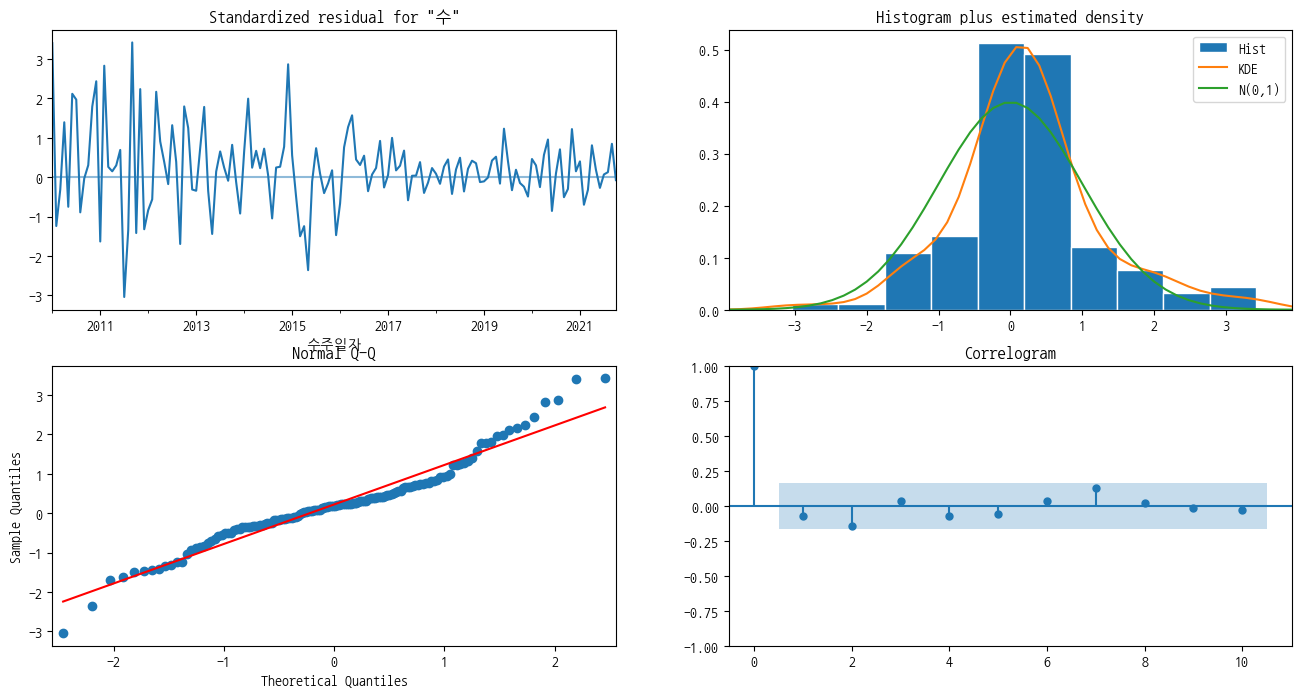

In [33]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [34]:
results.get_prediction()

In [35]:
y_dressing.head()

수주일자
2007-10-31    3217.500000
2007-11-30    4652.777778
2007-12-31    1254.437500
2008-01-31     787.600000
2008-02-29    2410.133333
Freq: M, Name: 수주수량KG, dtype: float64

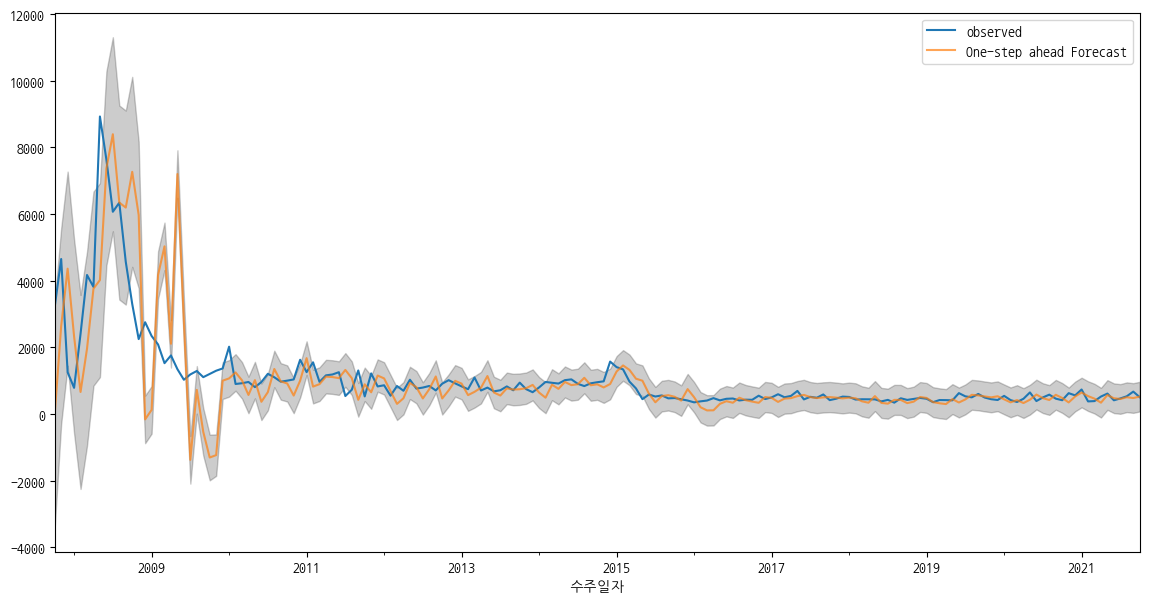

In [37]:
pred = results.get_prediction(start=pd.to_datetime('2007-10-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = y_dressing.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.2)

plt.legend()
plt.show()

In [38]:
pred = results.get_prediction(start=pd.to_datetime('2007-10-31'), dynamic=False)
pd.DataFrame(pred.predicted_mean).reset_index()

,수주일자,predicted_mean
0,2007-10-31,0.000000
1,2007-11-30,2640.511604
2,2007-12-31,4362.745358
3,2008-01-31,2327.129476
4,2008-02-29,664.207669
...,...,...
164,2021-06-30,475.445967
165,2021-07-31,453.295210
166,2021-08-31,505.589454
167,2021-09-30,481.600360


In [40]:
y_forecasted = pred.predicted_mean
y_truth = y_dressing['2007-10-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('MSE {}'.format(round(mse, 2)))

MSE 1157202.44


In [44]:
import numpy as np
np.sqrt(mse)

1075.7334431904596

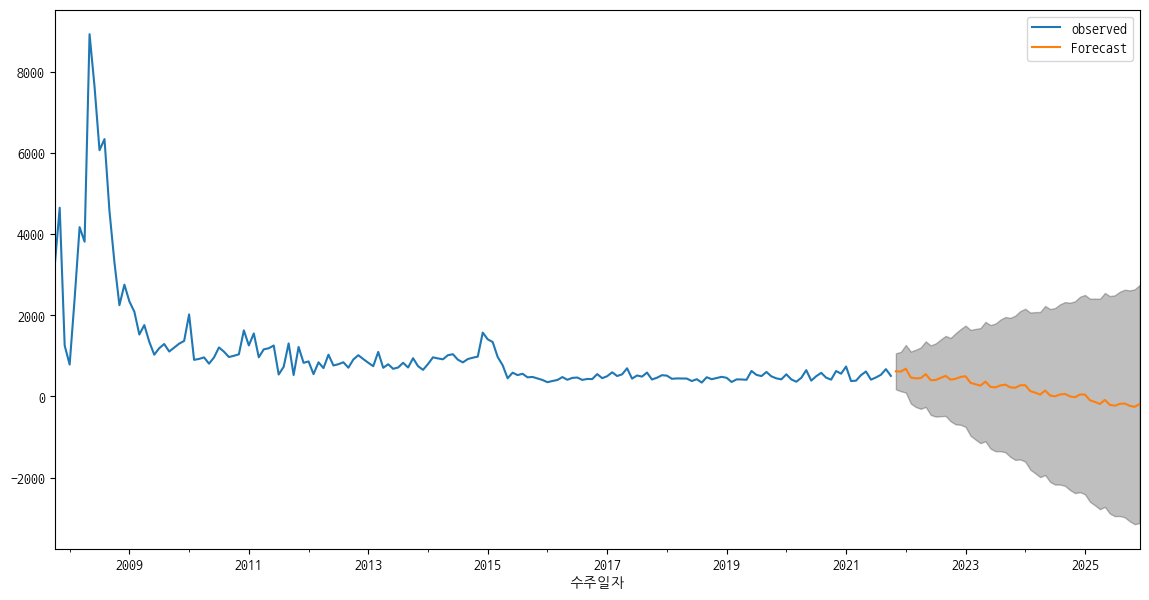

In [41]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int() #추정된 계수의 신뢰구간 계산
ax = y_dressing.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.25)

plt.legend()
plt.show()

# PROPHET 모델

In [ ]:
conda install -c conda-forge fbprophet

pip install cython

pip install pystan

# 납기 지연여부 분류 모델

## import

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import scipy.stats
from statsmodels.stats.proportion import proportions_ztest

import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import statsmodels.api as sm

from sklearn.tree import export_graphviz
# import graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

matplotlib.rc('font', family = 'NanumGothic')
matplotlib.rc('axes', unicode_minus = False)

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from statsmodels.tools.eval_measures import rmse

from statsmodels.api import Logit

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.tree import DecisionTreeClassifier
# from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import GradientBoostingClassifier
# from xgboost import XGBClassifier
# from xgboost import plot_importance
# from lightgbm import LGBMClassifier
# from lightgbm import plot_importance
# from catboost import CatBoostClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
pip install numpy==1.19.3 pandas scipy scikit-learn statsmodels matplotlib seaborn jupyter notebook

In [ ]:
## 데이터 불러오기 , 전처리

In [ ]:
df_book_gb = pd.read_csv("/home/piai/다운로드/df_book_gb.csv")
df_book_gb.info()

In [5]:
df_book_gb.drop('Unnamed: 0', axis=1, inplace=True)
df_book_gb.drop('label2.1', axis=1, inplace=True)

NameError: name 'df_book_gb' is not defined

In [6]:
mask = df_book_gb['label2'] == '소스'
df_book_gb = df_book_gb.loc[mask]
df_book_gb.drop('label2', axis=1, inplace=True)

NameError: name 'df_book_gb' is not defined

In [195]:
month_dict = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
              7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df_book_gb['수주월'] = df_book_gb['수주월'].replace(month_dict)

In [196]:
# df_book_gb = df_book_gb[['출하완료여부','수주사업장',  'label2','수주부서','수주수량', '수주단위', '수주수량KG', '수주단가', '수주금액', '기준단가']]

In [197]:
mask = df_book_gb['출하완료여부'] == 1
df_book_model1 = df_book_gb.loc[mask]
df_book_model1.info()
mask = df_book_gb['출하완료여부'] == 0
df_book_model0 = df_book_gb.loc[mask]
df_book_model0.info()
df_book_model1_train, df_book_model1_test = train_test_split(df_book_model1, test_size=0.02, random_state=3000)
df_book_model1_test.info()
model_df = pd.concat([df_book_model1_test, df_book_model0])
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46225 entries, 1 to 121623
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   출하완료여부  46225 non-null  int64  
 1   수주사업장   46225 non-null  float64
 2   수주월     46225 non-null  object 
 3   수주부서    46225 non-null  object 
 4   수주수량    46225 non-null  float64
 5   수주단위    46225 non-null  object 
 6   수주수량KG  46225 non-null  float64
 7   수주단가    46225 non-null  float64
 8   수주금액    46225 non-null  float64
 9   부가세금액   46225 non-null  int64  
 10  기준단가    46225 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 685 entries, 1962 to 121851
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   출하완료여부  685 non-null    int64  
 1   수주사업장   685 non-null    float64
 2   수주월     685 non-null    object 
 3   수주부서    685 non-null    object 
 4   수주수량    6

In [169]:
# df_book_gb.info()

In [170]:
# df_dummy = pd.get_dummies(df_book_gb)
# df_dummy.info()

In [198]:
df_dummy = pd.get_dummies(model_df)
df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1610 entries, 101377 to 121851
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   출하완료여부      1610 non-null   int64  
 1   수주사업장       1610 non-null   float64
 2   수주수량        1610 non-null   float64
 3   수주수량KG      1610 non-null   float64
 4   수주단가        1610 non-null   float64
 5   수주금액        1610 non-null   float64
 6   부가세금액       1610 non-null   int64  
 7   기준단가        1610 non-null   float64
 8   수주월_Apr     1610 non-null   uint8  
 9   수주월_Aug     1610 non-null   uint8  
 10  수주월_Dec     1610 non-null   uint8  
 11  수주월_Feb     1610 non-null   uint8  
 12  수주월_Jan     1610 non-null   uint8  
 13  수주월_Jul     1610 non-null   uint8  
 14  수주월_Jun     1610 non-null   uint8  
 15  수주월_Mar     1610 non-null   uint8  
 16  수주월_May     1610 non-null   uint8  
 17  수주월_Nov     1610 non-null   uint8  
 18  수주월_Oct     1610 non-null   uint8  
 19  수주월_Sep     1610 non

In [199]:
df_x = df_dummy.drop(["출하완료여부"], axis=1)
df_y = df_dummy["출하완료여부"]

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size=0.3, random_state=1234)

In [98]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(sampling_strategy="auto")
# x_resampled, y_resampled = sm.fit_resample(df_train_x,df_train_y)

# print("Over-Sampling 전 :\n",df_train_y.value_counts(),"\n")
# print("Over-Sampling 후 Train X:{}".format(x_resampled.shape))
# print("Over-Sampling 후 Train Y:{} \n".format(y_resampled.shape))
# print("Over-Sampling 후 '1':{}".format(sum(y_resampled==1)))
# print("Over-Sampling 후 '0':{}".format(sum(y_resampled==0)))

Over-Sampling 전 :
 1    4667
0      63
Name: 출하완료여부, dtype: int64 

Over-Sampling 후 Train X:(9334, 26)
Over-Sampling 후 Train Y:(9334,) 

Over-Sampling 후 '1':4667
Over-Sampling 후 '0':4667


## Decision Tree

In [134]:
tree_uncustomized = DecisionTreeClassifier(random_state=1234, max_depth=7, min_samples_split=10)
tree_uncustomized.fit(df_train_x,df_train_y)
y_pred = tree_uncustomized.predict(df_test_x)
print("train Accuracy: {0:.3f}\n".format(tree_uncustomized.score(df_train_x,df_train_y)))
print("test Accuracy: {0:.3f}\n".format(tree_uncustomized.score(df_test_x,df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y,y_pred)))
print(classification_report(df_test_y,y_pred, digits=3))

# , max_depth=8, min_samples_split=10

train Accuracy: 0.887

test Accuracy: 0.870

Confusion matrix: 
[[25  4]
 [ 5 35]]
              precision    recall  f1-score   support

           0      0.833     0.862     0.847        29
           1      0.897     0.875     0.886        40

    accuracy                          0.870        69
   macro avg      0.865     0.869     0.867        69
weighted avg      0.870     0.870     0.870        69



In [126]:
train_accuracy = []
test_accuracy = []
para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth=v_max_depth, random_state=1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy
df_accuracy_depth.round(3)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.688,0.623
1,2,0.756,0.725
2,3,0.794,0.812
3,4,0.825,0.812
4,5,0.875,0.768
5,6,0.906,0.783
6,7,0.925,0.812
7,8,0.938,0.797
8,9,0.950,0.812
9,10,0.962,0.783


In [131]:
train_accuracy = []
test_accuracy = []
para_split = [n_split*1 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_min_samples_split, max_depth=7, random_state=1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,2,0.925,0.812
1,3,0.925,0.812
2,4,0.919,0.841
3,5,0.906,0.826
4,6,0.906,0.826
5,7,0.906,0.826
6,8,0.894,0.826
7,9,0.888,0.870
8,10,0.888,0.870
9,11,0.869,0.812


In [133]:
train_accuracy = []
test_accuracy = []
para_leaf = [n_leaf*2 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(min_samples_leaf=v_min_samples_leaf, min_samples_split = 10, max_depth=7, random_state=1234)
    tree.fit(df_train_x,df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_leaf = pd.DataFrame()
df_accuracy_leaf["MinSamplesLeaf"] = para_leaf
df_accuracy_leaf["TrainAccuracy"] = train_accuracy
df_accuracy_leaf["TestAccuracy"] = test_accuracy
df_accuracy_leaf.round(3)

,MinSamplesLeaf,TrainAccuracy,TestAccuracy
0,2,0.875,0.855
1,4,0.844,0.783
2,6,0.856,0.768
3,8,0.844,0.812
4,10,0.775,0.681
5,12,0.725,0.652
6,14,0.694,0.623
7,16,0.694,0.623
8,18,0.694,0.623
9,20,0.694,0.623


In [100]:
# 변수명
v_feature_name = df_train_x.columns# 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = tree_uncustomized.feature_importances_# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
5,부가세금액,0.241
2,수주수량KG,0.216
4,수주금액,0.183
3,수주단가,0.180
6,기준단가,0.043
17,수주월_Oct,0.023
16,수주월_Nov,0.022
13,수주월_Jun,0.021
12,수주월_Jul,0.013
24,수주단위_EA,0.013


Text(0, 0.5, '설명변수')

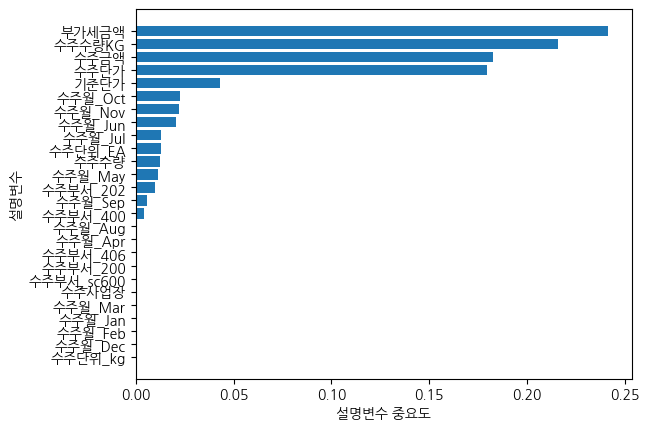

In [101]:
# 설명변수 중요도 그래프, 중요도 높은 변수를 상위에
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## 랜덤포레스트

In [149]:
rf_uncustomized = RandomForestClassifier(random_state=1234, n_estimators=80, max_depth=12)
rf_uncustomized.fit(df_train_x, df_train_y)
y_pred = rf_uncustomized.predict(df_test_x)
print("Score on train set:{0:.3f}".format(rf_uncustomized.score(df_train_x,df_train_y)))
print("Score on test set:{0:.3f}".format(rf_uncustomized.score(df_test_x,df_test_y)))
print(classification_report(df_test_y,y_pred, digits=3))

# , n_estimators=30, max_depth=14, min_samples_split=78

Score on train set:0.988
Score on test set:0.855
              precision    recall  f1-score   support

           0      0.880     0.759     0.815        29
           1      0.841     0.925     0.881        40

    accuracy                          0.855        69
   macro avg      0.860     0.842     0.848        69
weighted avg      0.857     0.855     0.853        69



In [139]:
train_score=[]
test_score=[]

para_n_tree = [n_tree*1 for n_tree in range(75,90)]

for v_n_estimators in para_n_tree:
    rf = RandomForestClassifier(n_estimators=v_n_estimators, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,75,0.988,0.826
1,76,0.988,0.826
2,77,0.988,0.841
3,78,0.988,0.841
4,79,0.988,0.841
5,80,0.988,0.855
6,81,0.988,0.855
7,82,0.988,0.855
8,83,0.988,0.841
9,84,0.988,0.855


In [142]:
train_score=[]
test_score=[]

para_depth = [depth for depth in range(7,30)]

for v_max_depth in para_depth:
    rf = RandomForestClassifier(random_state=1234, n_estimators=80, max_depth=v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["Depth"] = para_depth
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,Depth,TrainScore,TestScore
0,7,0.962,0.768
1,8,0.969,0.768
2,9,0.975,0.797
3,10,0.981,0.812
4,11,0.988,0.812
5,12,0.988,0.855
6,13,0.988,0.826
7,14,0.988,0.855
8,15,0.988,0.841
9,16,0.988,0.841


In [147]:
train_score=[]
test_score=[]

para_split = [n_split*1 for n_split in range(2,10)]

for v_min_samples_split in para_split:
    rf = RandomForestClassifier(random_state=1234, n_estimators=80, max_depth=12, min_samples_split=v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesSplit"] = para_split
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,2,0.988,0.855
1,3,0.988,0.812
2,4,0.969,0.768
3,5,0.962,0.812
4,6,0.956,0.812
5,7,0.944,0.812
6,8,0.912,0.797
7,9,0.919,0.797


In [148]:
train_score=[]
test_score=[]

para_leaf = [n_leaf*1 for n_leaf in range(1,11)]

for v_min_samples_leaf in para_leaf:
    rf = RandomForestClassifier(random_state=1234, n_estimators=80, max_depth=12, min_samples_split=2 ,min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    test_score.append(rf.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.988,0.855
1,2,0.931,0.797
2,3,0.894,0.754
3,4,0.875,0.725
4,5,0.831,0.667
5,6,0.831,0.667
6,7,0.812,0.638
7,8,0.800,0.638
8,9,0.788,0.623
9,10,0.794,0.623


In [104]:
# 변수명
v_feature_name = df_train_x.columns# 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_uncustomized.feature_importances_# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
2,수주수량KG,0.194
4,수주금액,0.181
5,부가세금액,0.176
6,기준단가,0.081
3,수주단가,0.075
16,수주월_Nov,0.058
13,수주월_Jun,0.037
17,수주월_Oct,0.034
15,수주월_May,0.024
12,수주월_Jul,0.022


## Gradient Boost

In [208]:
gb_uncustomized = GradientBoostingClassifier(random_state=1234, learning_rate=0.15, min_samples_leaf=2)
gb_uncustomized.fit(df_train_x, df_train_y)
y_pred = gb_uncustomized.predict(df_test_x)
print("Accuracy on train set:{0:.3f}".format(gb_uncustomized.score(df_train_x,df_train_y)))
print("Accuracy on test set:{0:.3f}".format(gb_uncustomized.score(df_test_x,df_test_y)))
print(classification_report(df_test_y,y_pred, digits=3))

# 
# , n_estimators=70, min_samples_leaf=4

Accuracy on train set:0.882
Accuracy on test set:0.785
              precision    recall  f1-score   support

           0      0.687     0.856     0.763       195
           1      0.883     0.736     0.803       288

    accuracy                          0.785       483
   macro avg      0.785     0.796     0.783       483
weighted avg      0.804     0.785     0.787       483



In [202]:
train_score=[]
test_score=[]

para_lr = [lr*0.005 for lr in range(20,50)]

for v_learning_rate in para_lr:
    gb = GradientBoostingClassifier(learning_rate=v_learning_rate, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["lr"] = para_lr
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,lr,TrainScore,TestScore
0,0.100,0.875,0.785
1,0.105,0.874,0.772
2,0.110,0.879,0.768
3,0.115,0.877,0.772
4,0.120,0.878,0.785
5,0.125,0.886,0.774
6,0.130,0.880,0.772
7,0.135,0.879,0.772
8,0.140,0.887,0.781
9,0.145,0.886,0.774


In [205]:
train_score=[]
test_score=[]

para_n_tree = [n_tree*5 for n_tree in range(18,30)]

for v_n_estimators in para_n_tree:
    gb = GradientBoostingClassifier(learning_rate=0.15, n_estimators=v_n_estimators, random_state=1234)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["TestScore"] = test_score
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,90,0.881,0.781
1,95,0.886,0.781
2,100,0.892,0.783
3,105,0.894,0.783
4,110,0.895,0.781
5,115,0.898,0.778
6,120,0.899,0.776
7,125,0.902,0.772
8,130,0.902,0.774
9,135,0.905,0.778


In [206]:
train_score=[]
test_score=[]

para_leaf = [n_leaf*1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    gb = GradientBoostingClassifier(random_state=1234, learning_rate=0.15 , n_estimators=100, min_samples_leaf=v_min_samples_leaf)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.892,0.783
1,2,0.882,0.785
2,3,0.880,0.774
3,4,0.890,0.772
4,5,0.886,0.760
5,6,0.878,0.776
6,7,0.878,0.774
7,8,0.882,0.768
8,9,0.881,0.768
9,10,0.881,0.772


In [209]:
train_score=[]
test_score=[]

para_depth = [depth for depth in range(1,21)]

for v_max_depth in para_depth:
    gb = GradientBoostingClassifier(random_state=1234, n_estimators=100, learning_rate=0.15, min_samples_leaf=2 ,max_depth=v_max_depth)
    gb.fit(df_train_x, df_train_y)
    train_score.append(gb.score(df_train_x, df_train_y))
    test_score.append(gb.score(df_test_x, df_test_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["Depth"] = para_depth
df_score_leaf["TrainScore"] = train_score
df_score_leaf["TestScore"] = test_score
df_score_leaf.round(3)

,Depth,TrainScore,TestScore
0,1,0.797,0.781
1,2,0.850,0.781
2,3,0.882,0.785
3,4,0.917,0.770
4,5,0.962,0.758
5,6,0.974,0.735
6,7,0.975,0.731
7,8,0.975,0.729
8,9,0.975,0.708
9,10,0.975,0.725


In [162]:
# 변수명
v_feature_name = df_train_x.columns# 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = gb_uncustomized.feature_importances_# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
16,수주월_Nov,0.139
6,기준단가,0.136
2,수주수량KG,0.128
4,수주금액,0.078
5,부가세금액,0.071
15,수주월_May,0.071
13,수주월_Jun,0.069
3,수주단가,0.058
0,수주사업장,0.047
7,수주월_Apr,0.041


Text(0, 0.5, '설명변수')

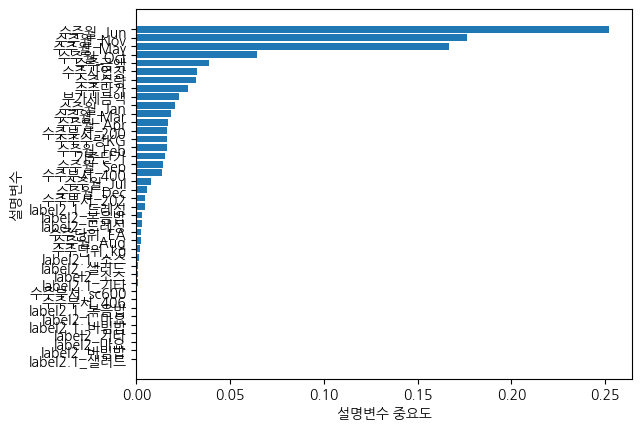

In [17]:
# 설명변수 중요도 그래프, 중요도 높은 변수를 상위에
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## XGBoost

In [121]:
xgboost_uncust = XGBClassifier(random_state=3000)
xgboost_uncust.fit(df_train_x, df_train_y)
y_pred = xgboost_uncust.predict(df_test_x)
print("Accuracy on train set:{0:.3f}".format(xgboost_uncust.score(df_train_x,df_train_y)))
print("Accuracy on test set:{0:.3f}".format(xgboost_uncust.score(df_test_x,df_test_y)))
print(classification_report(df_test_y,y_pred, digits=3))

Accuracy on train set:0.988
Accuracy on test set:0.768
              precision    recall  f1-score   support

           0      0.760     0.655     0.704        29
           1      0.773     0.850     0.810        40

    accuracy                          0.768        69
   macro avg      0.766     0.753     0.757        69
weighted avg      0.767     0.768     0.765        69



In [122]:
# 변수명
v_feature_name = df_train_x.columns# 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = xgboost_uncust.feature_importances_# df_feature_importance의 테이블을 중요도 순으로 정렬
df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
11,수주월_Jan,0.178
7,수주월_Apr,0.170
10,수주월_Feb,0.097
0,수주사업장,0.095
16,수주월_Nov,0.084
15,수주월_May,0.067
6,기준단가,0.064
12,수주월_Jul,0.056
13,수주월_Jun,0.040
17,수주월_Oct,0.026


Text(0, 0.5, '설명변수')

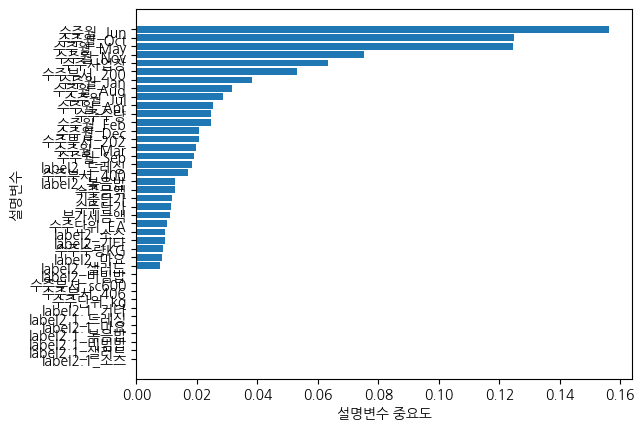

In [20]:
# 설명변수 중요도 그래프, 중요도 높은 변수를 상위에
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width=df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")

## 서포트 벡터 머신

In [120]:
svm_uncustomized = SVC(random_state=1234)
svm_uncustomized.fit(df_train_x, df_train_y)
y_pred = svm_uncustomized.predict(df_test_x)
print("Score on train set:{0:.3f}".format(svm_uncustomized.score(df_train_x,df_train_y)))
print("Score on test set:{0:.3f}".format(svm_uncustomized.score(df_test_x,df_test_y)))
print(classification_report(df_test_y,y_pred, digits=3))

Score on train set:0.588
Score on test set:0.580
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        29
           1      0.580     1.000     0.734        40

    accuracy                          0.580        69
   macro avg      0.290     0.500     0.367        69
weighted avg      0.336     0.580     0.425        69



/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 인공신경망

In [119]:
nn_uncustomized = MLPClassifier(random_state=1234)
nn_uncustomized.fit(df_train_x, df_train_y)
y_pred = nn_uncustomized.predict(df_test_x)
print("Score on train set:{0:.3f}".format(nn_uncustomized.score(df_train_x,df_train_y)))
print("Score on test set:{0:.3f}".format(nn_uncustomized.score(df_test_x,df_test_y)))
print(classification_report(df_test_y,y_pred, digits=3))

Score on train set:0.588
Score on test set:0.580
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        29
           1      0.580     1.000     0.734        40

    accuracy                          0.580        69
   macro avg      0.290     0.500     0.367        69
weighted avg      0.336     0.580     0.425        69



/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/piai/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 그리드서치

In [118]:
# 그리드서치를 위한 각 모델들의 조회할 파라미터 지정
models = {
    'DecisionTreeClassifier': (DecisionTreeClassifier(),{'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10, 20]}),
    'RandomForestClassifier': (RandomForestClassifier(), {'n_estimators': [100, 200, 500], 'max_depth': [5, 10, 20, None]}),
    'GradientBoostingClassifier': (GradientBoostingClassifier(), {'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 10]})
}

# 각 모델마다 그리드서치 실행 및 결과 출력
for model_name, (model, param_grid) in models.items():
    print(f"Running GridSearchCV for {model_name}...")
    clf = GridSearchCV(model, param_grid, cv=5)
    clf.fit(df_train_x, df_train_y.values.ravel())
    print(f"Best parameters: {clf.best_params_}")
    print(f"Train score: {clf.best_score_}")
    print(f"Test score: {clf.score(df_test_x, df_test_y.values.ravel())}")

Running GridSearchCV for DecisionTreeClassifier...
Best parameters: {'criterion': 'gini', 'max_depth': 5}
Train score: 0.75625
Test score: 0.7971014492753623
Running GridSearchCV for RandomForestClassifier...
Best parameters: {'max_depth': 10, 'n_estimators': 500}
Train score: 0.8
Test score: 0.782608695652174
Running GridSearchCV for GradientBoostingClassifier...
Best parameters: {'learning_rate': 0.1, 'max_depth': 3}
Train score: 0.7875
Test score: 0.7971014492753623
